In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan
from lmfit.models import GaussianModel
import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv') #most updated table

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

srcns = np.array(alls['src_n'])
#saving figure function
def sf(name,dpi=150):
    plt.savefig(f'Figs/{name}.png',bbox_inches='tight',dpi=dpi)
#simple plotting function
def plot(s,calib=False,both=True):
    try:band = o.getIV(s,cross,both=both,stack=True,plot=True,mlist=mlist1,figsize=(4,3),calib=calib)
    except:band = o.getIV(s,cross2,both=both,stack=True,plot=True,mlist=mlist2,figsize=(4,3),calib=calib)

# Fake Example

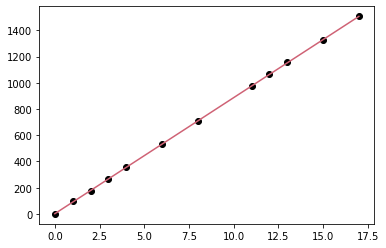

In [2]:
guess = 88.5
test = np.array([55998.9,56094.4,56175.6,56264.1,56356.3,56529.0,56708.0,56974.7,57063.1,57153.5,57325.3,57506.2])
xax = np.around((test - test[0])/guess)
yax = test - test[0]
dec = yax/guess - xax
line = np.polyfit(xax,yax,1)
plt.scatter(xax,yax,color='black')
plt.plot(xax,xax*line[0]+line[1],color=pink)

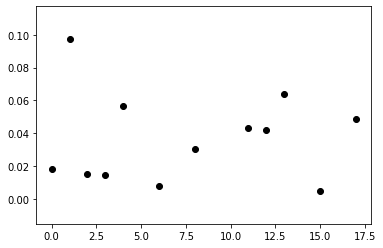

In [3]:
#plot residuals
res = (yax - xax*line[0]+line[1])/88.5
plt.scatter(xax,res,color='black')

In [4]:
per = [50,60,72,80,24]
li = [5,6,7,8,2]
ind = np.where(li==np.min(li))[0][0]
per[ind]

24

idea of dictionary
- each source number gets two lists/arrays: periods and stdevs

In [2]:
xlist = [7,12,31,37,11,13,6,27,2,3,12,44,49,56,60,9,23,36,54] #list of sources with X-ray-derived periods
xstr = [] #list of X-ray source numbers as strings
for x in xlist: xstr.append(str(x))
# xstr

In [6]:
xdict = dict((k, []) for k in xstr)

In [7]:
xdict #and replace dictionary element with periods and stdevs

{'7': [],
 '12': [],
 '31': [],
 '37': [],
 '11': [],
 '13': [],
 '6': [],
 '27': [],
 '2': [],
 '3': [],
 '44': [],
 '49': [],
 '56': [],
 '60': [],
 '9': [],
 '23': [],
 '36': [],
 '54': []}

In [7]:
#loop through with different periods
def toaloop(toas,start,end,step,color='black',label='',retbest=False,addtodict=False,plot=True,retstd=False):
    '''
    Loop through periods and plot the standard deviation of the decimal part of cycle numbers between ToAs
    toas: list or array of times of arrival
    start: starting period in loop
    end: end period in loop
    step: stepsize in loop
    color: color of curve in plot
    label: label for curve (but legend must be called separately)
    retbest: return the best period within loop (period with lowest standard deviation)
    '''
    stds = []
    periods = np.arange(start,end,step)
    for p in periods:
        yax = toas - toas[0]
        #divide toa by period and round to nearest whole num
        xax = np.around(yax/p)
        #get difference between yax/p and nearest integer
        dec = yax/p - xax
        stds.append(np.nanstd(dec))
    if plot:plt.plot(periods,stds,color=color,label=label)
    #if dictionary passed in
    if addtodict:
        if 'xdict' in globals():
            #use most recently defined src
            key = str(int(src))
            xdict[key] = (periods,stds) #tuple of periods and stdevs 
    #return best period (one with lowest standard deviation)
    if retbest:
        bpind = np.where(stds==np.nanmin(stds))[0][0]
        bp = periods[bpind]
        if retstd:return stds,bp
        else: return bp

88.51000000008838


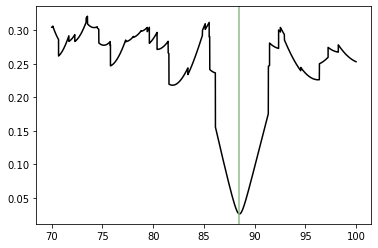

In [9]:
bestp = toaloop(test,70,100,0.001,retbest=True,addtodict=False)
plt.axvline(88.5,color='darkseagreen')
print(bestp)

# Functions to Get ToAs
- fold with guess period and get time of maximum (optical minimum) for each or center using gaussian fit
- year function works for one year; year loop goes through all years of LC

In [4]:
def year(ib,p,n=1,mult=1,pbins=16,det=True,plotphase=False,minpoints=100,retref=False,gauss=False):
    '''
    Find TOA of maximum for the nth year of iband data
    --> now also requires that there are minpoints in that year (same start date, but extends if need be)
    ib: I band table, with or without detrended I mag
    p: initial period guess in days
    n: year of data (starting at 1)
    mult: multiples of year to include (e.g., 1 gives 1*365 days)
    pbins: number of phase bins
    det: whether or not to use spline-detrended data in phase-folding
    plotphase: for debugging mostly, plot the phase-folded data
    retref: return TOAs, reference time (necessary since not yearly 
            spacing once min points requirement)
    '''
    #if column of detrended not already there, detrend
    if 'I detrend' not in ib.columns: o.splinedetrend(ib)
    #add column of initial indices
    ib['ind'] = np.arange(len(ib))
    #first time in overall table
    t0 = ib['MJD-50000'][0]
    
    #make filtered table with just nth year
    y = ib[ib['MJD-50000']>t0+(n-1)*365*mult] #n for year number and mult for years/chunk
    if len(y)==0: return 'not enough left'
    #get first index

    init_ind = y['ind'][0]
    #upper bound
    y = y[y['MJD-50000']<t0+n*365*mult] #n for year number and mult for years/chunk

    #check that there are sufficient points
    if len(y)<minpoints:
        y = ib[init_ind:init_ind+minpoints]
    #new 0 time
    nt0 = float(y['MJD-50000'][0])

    #find reference time
    ref = nt0 #reference time beginning of current year
    
    #subtract reference time from all times in year table
    y['MJD-50000'] -= ref
    
    #phase-fold year of data
    mid,avg,err = o.meanphase(y,p,pbins=pbins,det=det,double=True,sterr=True,stdev=True,divide=True)
    #for debugging: plot phase
    if plotphase:
        plt.figure(figsize=(4,3))
        plt.step(mid,avg,where='mid',color='black')
        #add errors as one sigma
        plt.errorbar(mid,avg,yerr=err,color='black',marker='',linestyle='none',alpha=0.4)
        #flip y axis 
        maxa,mina = np.nanmax(avg),np.nanmin(avg)
        maxa += np.nanmax(err)
        mina -= np.nanmax(err)
        plt.ylim(maxa+.01,mina-.01)
    
    #find peak (min since in magnitudes)
    #using gaussian fit
    if gauss:
        x = mid[:16]
        imag = avg[:16]
        y = np.nanmax(imag) - imag 
        mod = GaussianModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x,nan_policy='omit')
        peakp = out.params['center'].value
    #using min
    else:
        peakp = mid[avg==np.nanmin(avg)][0] #phase loc of folded max
    maxday = p*peakp #peak in days (phase*period)
    #return time of arrival and reference time used
    if retref: return nt0+maxday,ref
    #return just toa
    return nt0+maxday

In [5]:
#newer version based on notes above (from 4/29 meeting)
def yearloop(src,p,mult=1,pbins=16,det=True,plotphase=False,findpd='no',minpoints=100,gauss=False,retpd=False):
    '''
    loop through all years of LC src
    arguments the same, but source number rather than iband given
    just return list of all ToAs
    '''
    #get iband LC
    try: iband = o.getIV(src,cross,stack=True,both=False,mlist=mlist1)
    except: iband = o.getIV(src,cross2,stack=True,both=False,mlist=mlist2)
    #if findpd not no, overwrite p with est. period or best auto det pd
    if findpd == 'est': p = float(alls[alls['src_n']==src]['est. period'])
    if findpd == 'best' or p == 0:p = float(alls[alls['src_n']==src]['best auto det pd'])
    
    #find number of years of data
    time = iband['MJD-50000']
    nyr = int((time[-1]-time[0])/365)
    #list of TOAs 
    toas = []
    ref_times = []
    for i in range(1,nyr+1):
        rets = year(iband,p=p,n=i,mult=mult,pbins=pbins,det=det,plotphase=plotphase,minpoints=minpoints,retref=True,gauss=gauss)
        if rets == 'not enough left': break
        else: toas.append(rets[0]); ref_times.append(rets[1])
    
    #new version
    toas = np.array(toas)
    if retpd: return toas, p
    return toas   

In [7]:
toas = yearloop(28,0,findpd='est',gauss=False,minpoints=30)
toas

array([2167.368365, 2518.833215, 2875.880815, 3236.346975, 3583.793455,
       3938.758815, 4288.102605, 4729.428425, 5434.871655, 5519.343705,
       5798.881805, 6239.855645, 6583.469365, 6934.306055, 7200.701145,
       7647.959955, 7990.890235, 8355.390255])

#### don't use gaussian for now -- need to fix

In [8]:
toas32 = yearloop(28,0,pbins=32,findpd='est',gauss=False)
toas8 = yearloop(28,0,pbins=8,findpd='est',gauss=False)
#trying different min points
toas_min50 = yearloop(28,0,pbins=8,findpd='est',gauss=False,minpoints=50)
toas_min200 = yearloop(28,0,pbins=8,findpd='est',gauss=False,minpoints=200)
toas = yearloop(28,89,findpd='no',gauss=False)

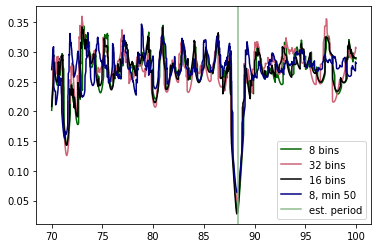

In [10]:
#illustrating effect of different numbers of phase bins
toaloop(toas8,70,100,0.0001,color='darkgreen',label='8 bins',addtodict=False)
toaloop(toas32,70,100,0.01,color=pink,label='32 bins')
toaloop(toas,70,100,0.01,label='16 bins',addtodict=False)
toaloop(toas_min50,70,100,0.01,label='8, min 50',color='navy',addtodict=False)
# toaloop(toas_min200,70,100,0.01,label='8, min 200',color='goldenrod') #not as good

plt.axvline(88.34,color='darkseagreen',label='est. period')
plt.legend()

In [11]:
toas96 = yearloop(96,17.55,findpd='no',gauss=False)

Text(0, 0.5, 'Stdev of Dec')

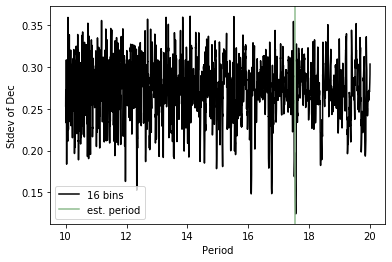

In [13]:
#important for this one to have a fine grid to pick up the minimum
toaloop(toas96,10,20,0.001,label='16 bins',addtodict=False)

plt.axvline(17.55,color='darkseagreen',label='est. period')
plt.legend()
plt.xlabel('Period')
plt.ylabel('Stdev of Dec')

In [6]:
def res(toas,pd,retfit=False,order=1):
    xax = np.around((toas - toas[0])/pd)
    yax = toas - toas[0]
    fit = np.polyfit(xax,yax,order)
    if order==1:eqn = xax*fit[0]+fit[1]
    else: eqn = fit[0]*xax**2+xax*fit[1]+fit[2] #only works for quadratic currently
    #divide by period to be in terms of phase
    res = yax - eqn
    res /= pd
    fig,(ax,ax1) = plt.subplots(1,2,figsize=(12,4))
    ax.scatter(xax,yax,color='black',label=f'P:{pd:.2f}')
    if order==1: label = f'slope: {fit[0]:.2f}'
    else: label = f'P:{fit[1]:.2f}, Pdot:{fit[0]:.2f}'
    ax.plot(xax,eqn,color=pink,label=label)
    ax.set_ylabel('ToAs - first ToA',fontsize=14)
    ax.set_xlabel('Rounded Cycle #',fontsize=14)
    ax1.scatter(xax,res,color='black')
    ax1.set_ylabel('Residuals/Pd',fontsize=14)
    plt.subplots_adjust(wspace=0.25)
    ax.legend()
    if retfit: return fit

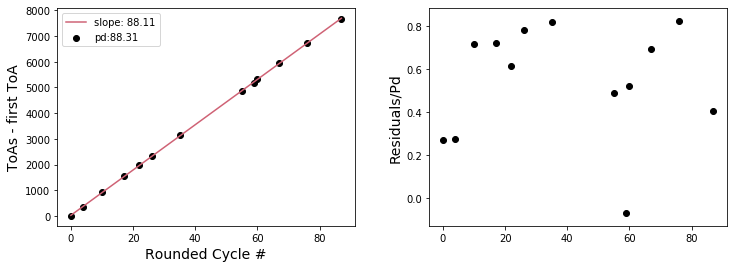

In [15]:
res(toas,88.31)

# Analyze Sources with Est. From X-ray

xlist = [7,12,31,37,11,13,6,27,2,3,12,44,49,56,60,9,23,36,54]

In [13]:
src = xlist[0]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)

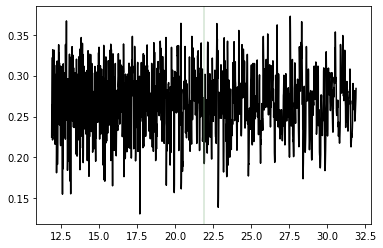

In [14]:
toaloop(toas,pd-10,pd+10,0.01,color='black',debug=True)
plt.axvline(pd,color='darkseagreen',alpha=0.4)

In [15]:
xdict['7'][0][:3]

array([11.9 , 11.91, 11.92])

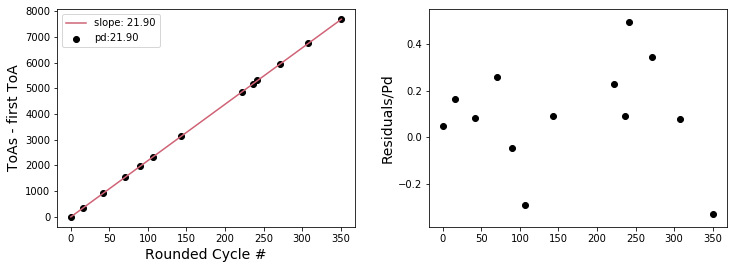

In [16]:
res(toas,pd)

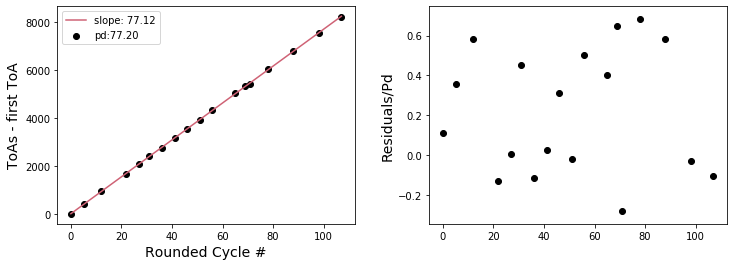

In [17]:
src = xlist[1]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 77.2, best: 80.85


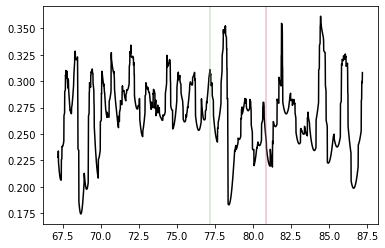

In [18]:
toaloop(toas,pd-10,pd+10,0.01,color='black')
plt.axvline(pd,color='darkseagreen',alpha=0.4,label='est.')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

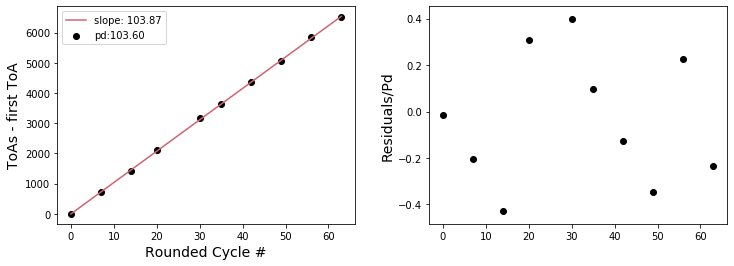

In [19]:
src = xlist[2]
toas,pd = yearloop(src,0,findpd='est',mult=2,gauss=False,retpd=True)
res(toas,pd)

est: 103.6, best: 101.12


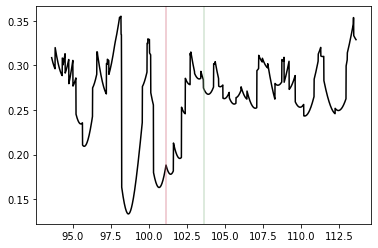

In [20]:
#probably within error, but pursue lower periods
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
plt.axvline(pd,color='darkseagreen',alpha=0.4,label='est.')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

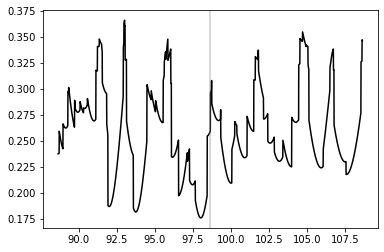

In [22]:
#re-fold with best period to see if maintained
toas,pd = yearloop(src,minp,findpd='no',mult=2,gauss=False,retpd=True)
toaloop(toas,minp-10,minp+10,0.01,color='black')
plt.axvline(pd,color='grey',alpha=0.4,label='est.')

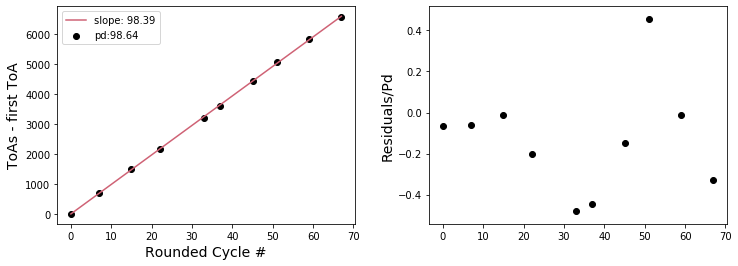

In [23]:
res(toas,minp) #better...

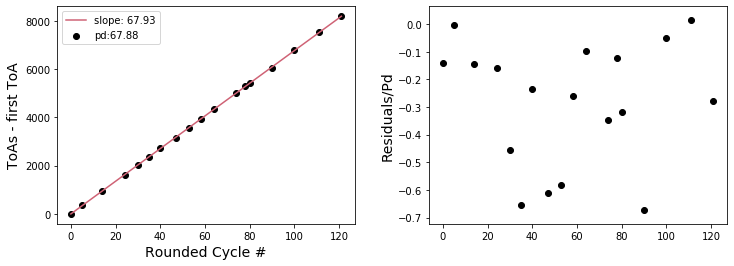

In [24]:
#why are they all negative residuals?
src = xlist[3]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 67.88, best: 68.59


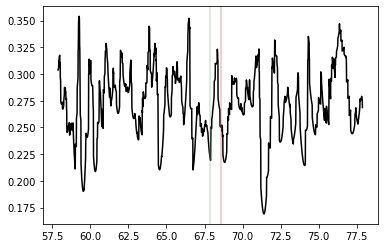

In [25]:
toaloop(toas,pd-10,pd+10,0.01,color='black')
plt.axvline(pd,color='darkseagreen',alpha=0.4,label='est.')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 67.88, best: 68.59


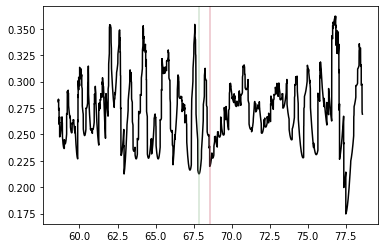

In [26]:
#testing doing initial fold with best
src = xlist[3]
toas,pd = yearloop(src,0,findpd='best',gauss=False,retpd=True)
toaloop(toas,pd-10,pd+10,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

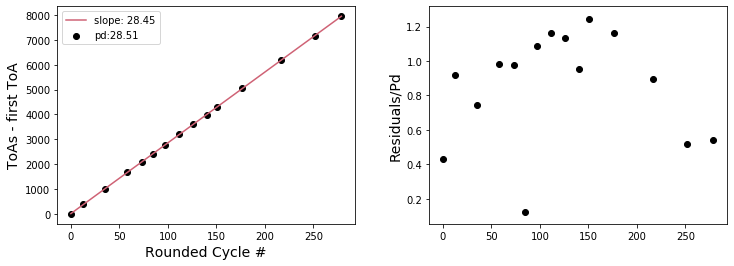

In [27]:
#interesting pattern? and compare to other bins
src = xlist[4]
toas,pd = yearloop(src,0,pbins=16,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 28.51, best: 28.49


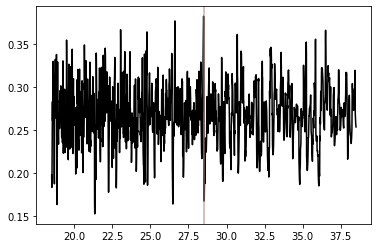

In [28]:
toaloop(toas,pd-10,pd+10,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

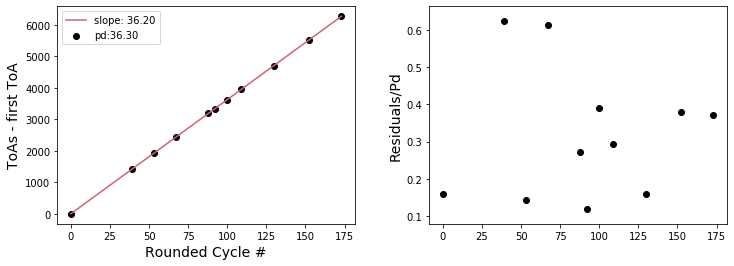

In [29]:
src = xlist[5]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 36.3, best: 36.24


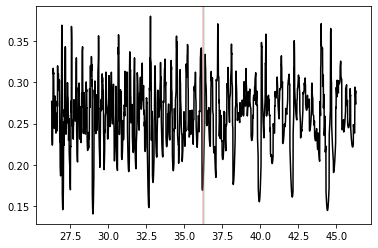

In [30]:
toaloop(toas,pd-10,pd+10,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

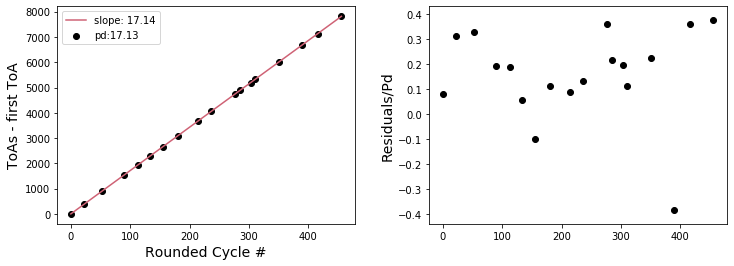

In [31]:
src = xlist[6]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 17.13, best: 17.35


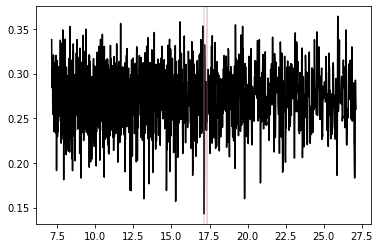

In [32]:
toaloop(toas,pd-10,pd+10,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
print(f'est: {est}, best: {best:.2f}')

est: 17.13, best: 17.35


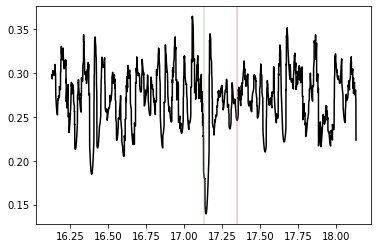

In [33]:
#expanding the example above
src = xlist[6]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
toaloop(toas,pd-1,pd+1,0.0001,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

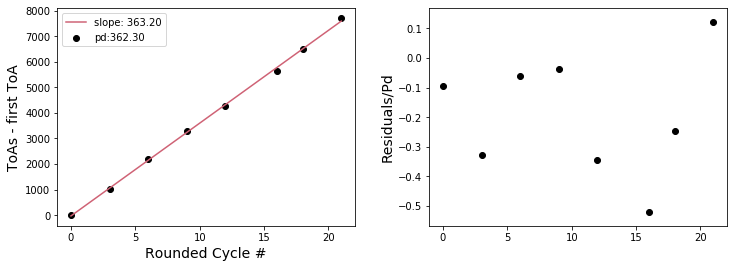

In [38]:
src = xlist[7]
toas,pd = yearloop(src,0,mult=3,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 362.3, best: 326.15


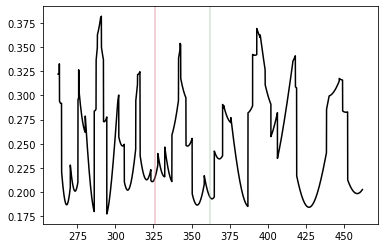

In [39]:
toaloop(toas,pd-100,pd+100,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

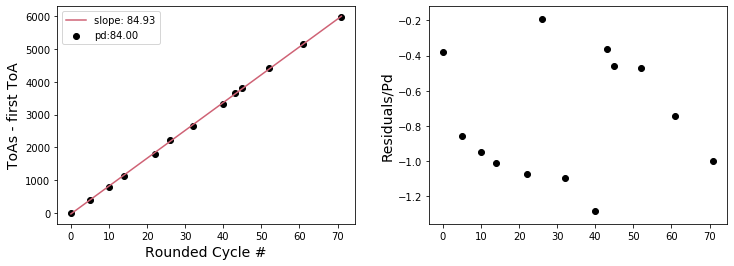

In [40]:
#interesting/meaningful pattern
src = xlist[8]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

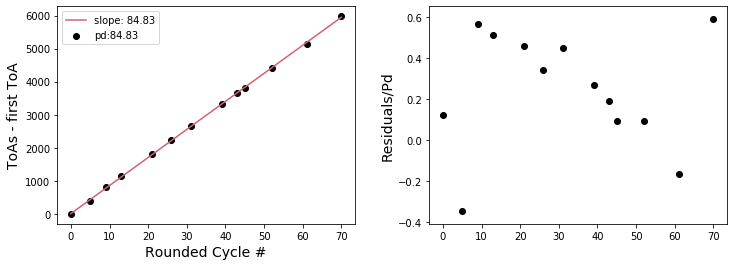

In [41]:
res(toas,84.83) #notice matching of slope and period, but residuals still patterned

est: 84.0, best: 83.99


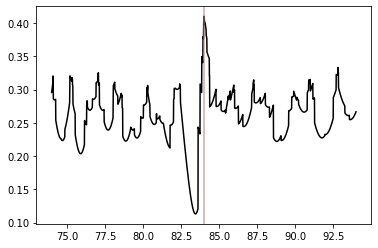

In [42]:
#interesting disagreement and perhaps within error
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

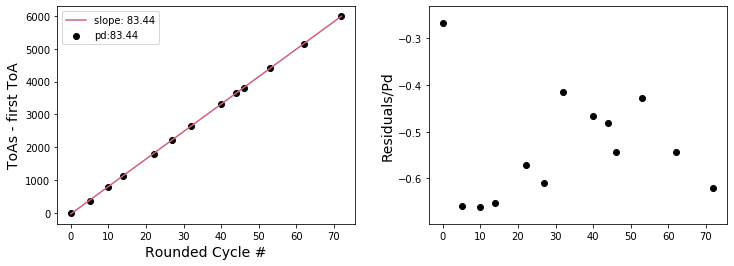

In [54]:
# now using best from below
res(toas,minp)

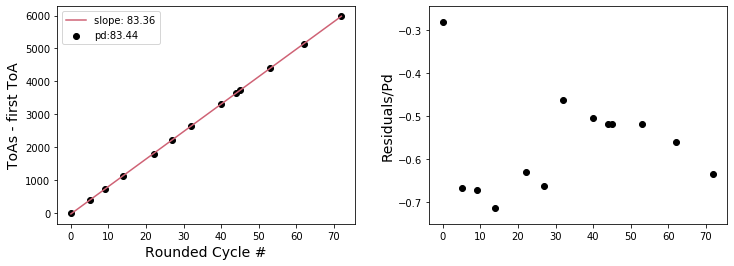

In [42]:
#now test using this period for original folding -- doesn't change too much
toas,pd = yearloop(src,minp,findpd='no',gauss=False,retpd=True)
res(toas,pd)

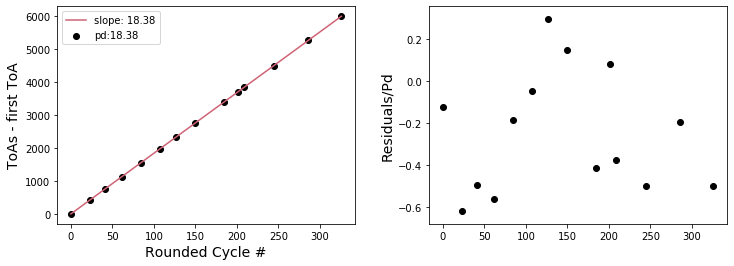

In [43]:
#notice slope same as period
src = xlist[9]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 18.38, best: 17.40


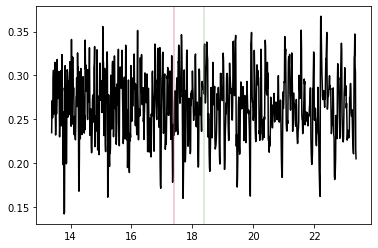

In [44]:
toaloop(toas,pd-5,pd+5,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
print(f'est: {est}, best: {best:.2f}')

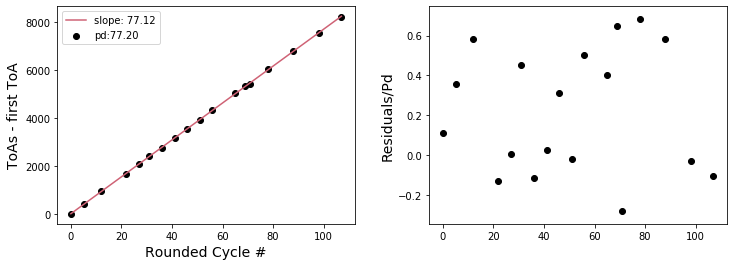

In [45]:
src = xlist[10]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 77.2, best: 80.85


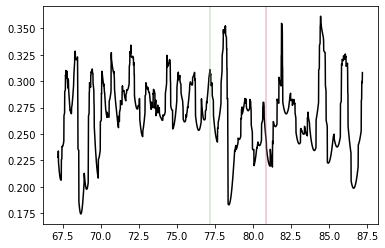

In [46]:
toaloop(toas,pd-10,pd+10,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

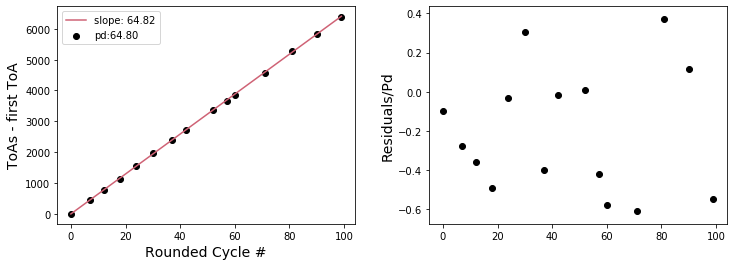

In [47]:
src = xlist[11]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 64.8, best: 63.57


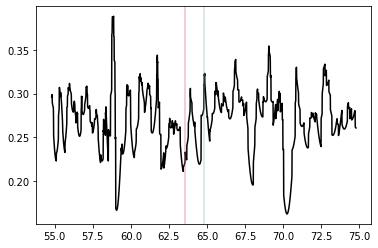

In [48]:
toaloop(toas,pd-10,pd+10,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

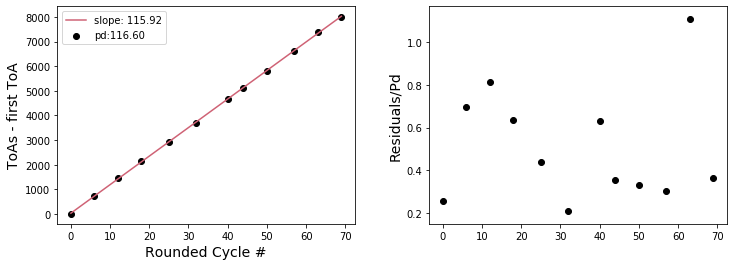

In [49]:
src = xlist[12]
toas,pd = yearloop(src,0,mult=2,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 116.6, best: 105.00


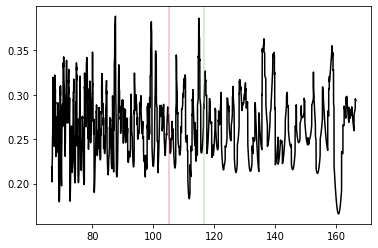

In [50]:
toaloop(toas,pd-50,pd+50,0.01,color='black')
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

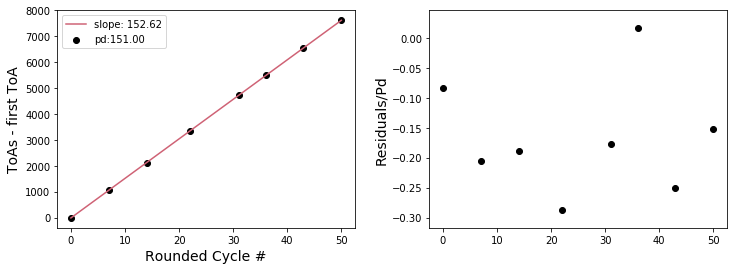

In [51]:
src = xlist[13]
toas,pd = yearloop(src,0,mult=3,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 151.0, best: 153.51


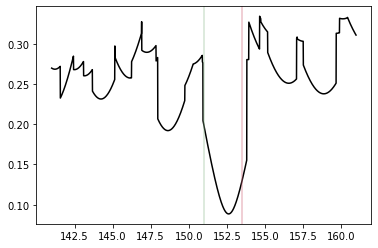

In [52]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

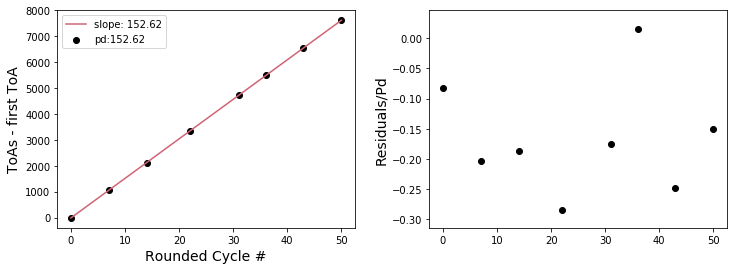

In [53]:
res(toas,minp) #minimum from above

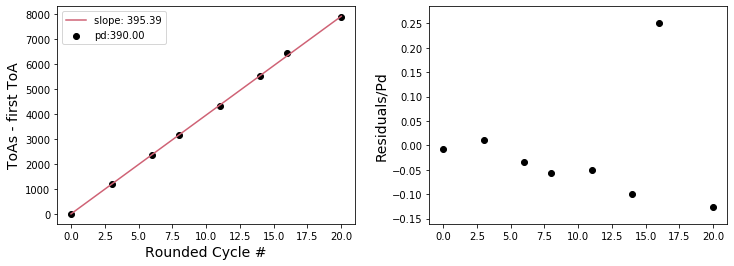

In [54]:
src = xlist[14] #residual drift
toas,pd = yearloop(src,0,mult=3,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 390.0, best: 350.69


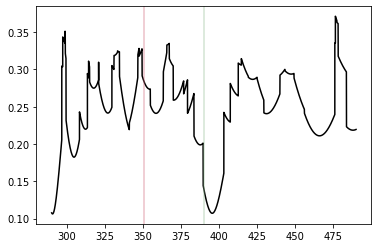

In [55]:
#good case for X-ray
minp = toaloop(toas,pd-100,pd+100,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

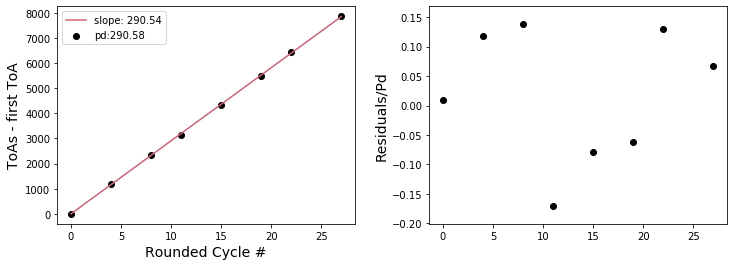

In [56]:
res(toas,minp) #best from above

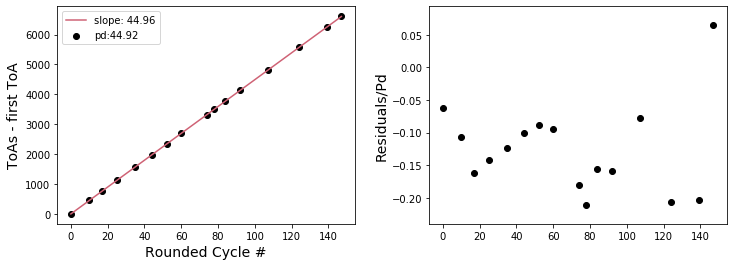

In [57]:
src = xlist[15]
toas,pd = yearloop(src,0,mult=1,findpd='est',gauss=False,retpd=True)
res(toas,pd) #interesting pattern

est: 44.92, best: 44.90


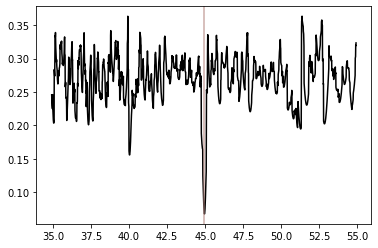

In [58]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
print(f'est: {est}, best: {best:.2f}')

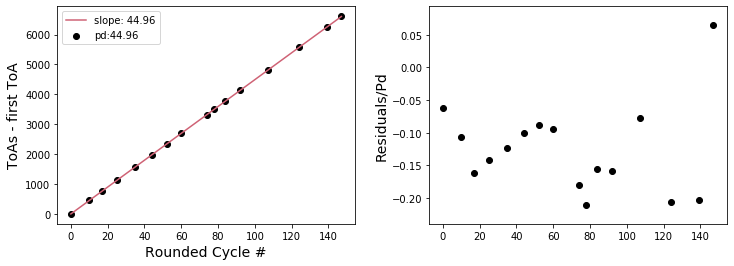

In [63]:
res(toas,minp) #best from above still gives this pattern; notice mostly negative

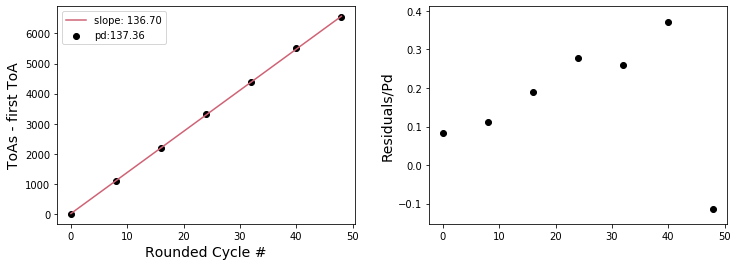

In [59]:
src = xlist[16]
toas,pd = yearloop(src,0,mult=3,findpd='est',gauss=False,retpd=True)
res(toas,pd)

est: 137.36, best: 137.92


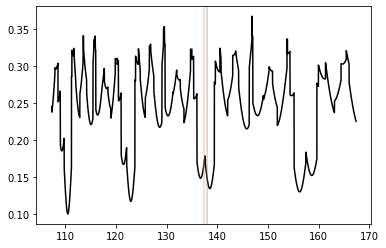

In [61]:
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
print(f'est: {est}, best: {best:.2f}')

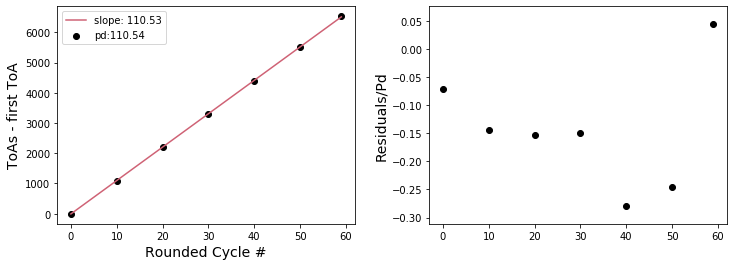

In [62]:
res(toas,minp) #between the X-ray and periodogram result but error unclear

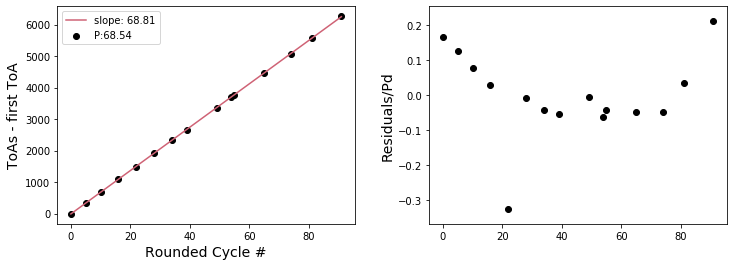

In [94]:
#important pattern
src = xlist[17]
toas,pd = yearloop(src,0,findpd='est',gauss=False,retpd=True,pbins=16)
linres = res(toas,68.54)

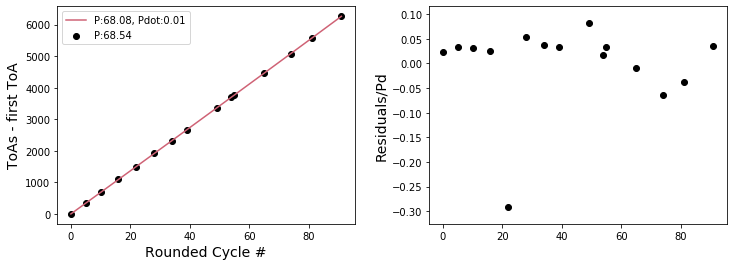

In [95]:
res(toas,pd,order=2)

est: 68.54, best: 68.62


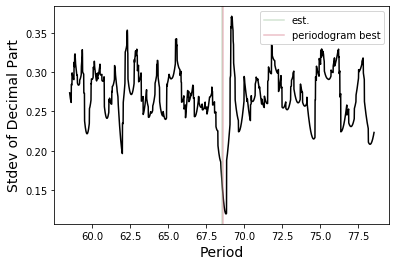

In [75]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')
plt.ylabel('Stdev of Decimal Part',fontsize=14)
plt.legend()
plt.xlabel('Period',fontsize=14)
# sf('toa_stv_ex')

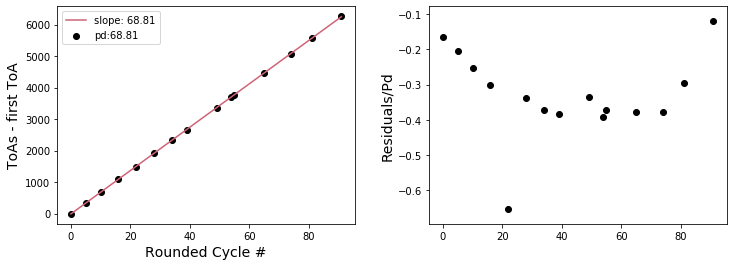

In [76]:
res(toas,minp)
# sf('toa_res_ex')

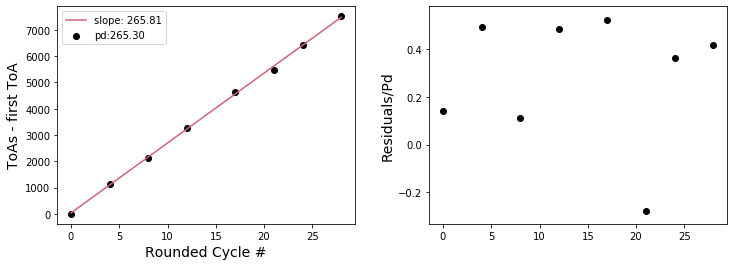

In [67]:
src = xlist[18]
toas,pd = yearloop(src,0,mult=3,findpd='est',gauss=False,retpd=True)
res(toas,pd) 

est: 265.3, best: 271.32


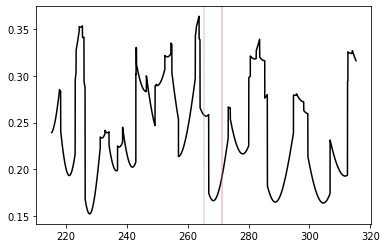

In [68]:
minp = toaloop(toas,pd-50,pd+50,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

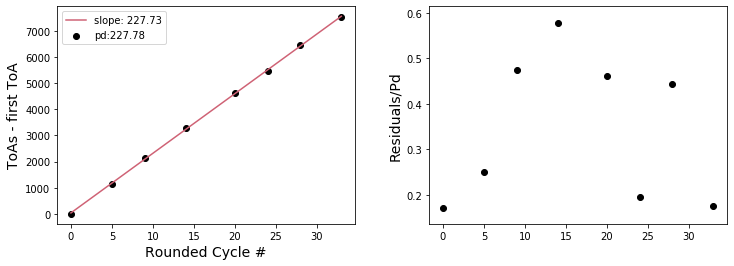

In [69]:
res(toas,minp) #residuals not significantly lower

## summary of results from sources with established from X-ray
- will have to fix (and write out new npz) since a couple results different b/c mult arg fixed

In [89]:
alls[alls['src_n']==7]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
5      7  15.722455 -72.74299         6.85   0.5         21.9  0.421283  NaN   

      mean I   stdev I  ...  rel max std 5  min std 5  det stdev I  \
5  14.721636  0.219999  ...       0.752474   0.009351     0.021746   

   det stdev/I range  base num   det IQR  calibration flag  stdev ratio  \
5           0.024683     0.497  0.022225               0.0     0.098844   

  IQR ratio sig stdev ratio  
5  0.075338        0.078781  

[1 rows x 89 columns]

In [70]:
#get all established periods
xpers = []
xopers = []
for x in xlist:
    row = alls[alls['src_n']==x]
    est = float(row['est. period'])
    auto = float(row['best auto det pd'])
    xpers.append(est)
    xopers.append(auto)

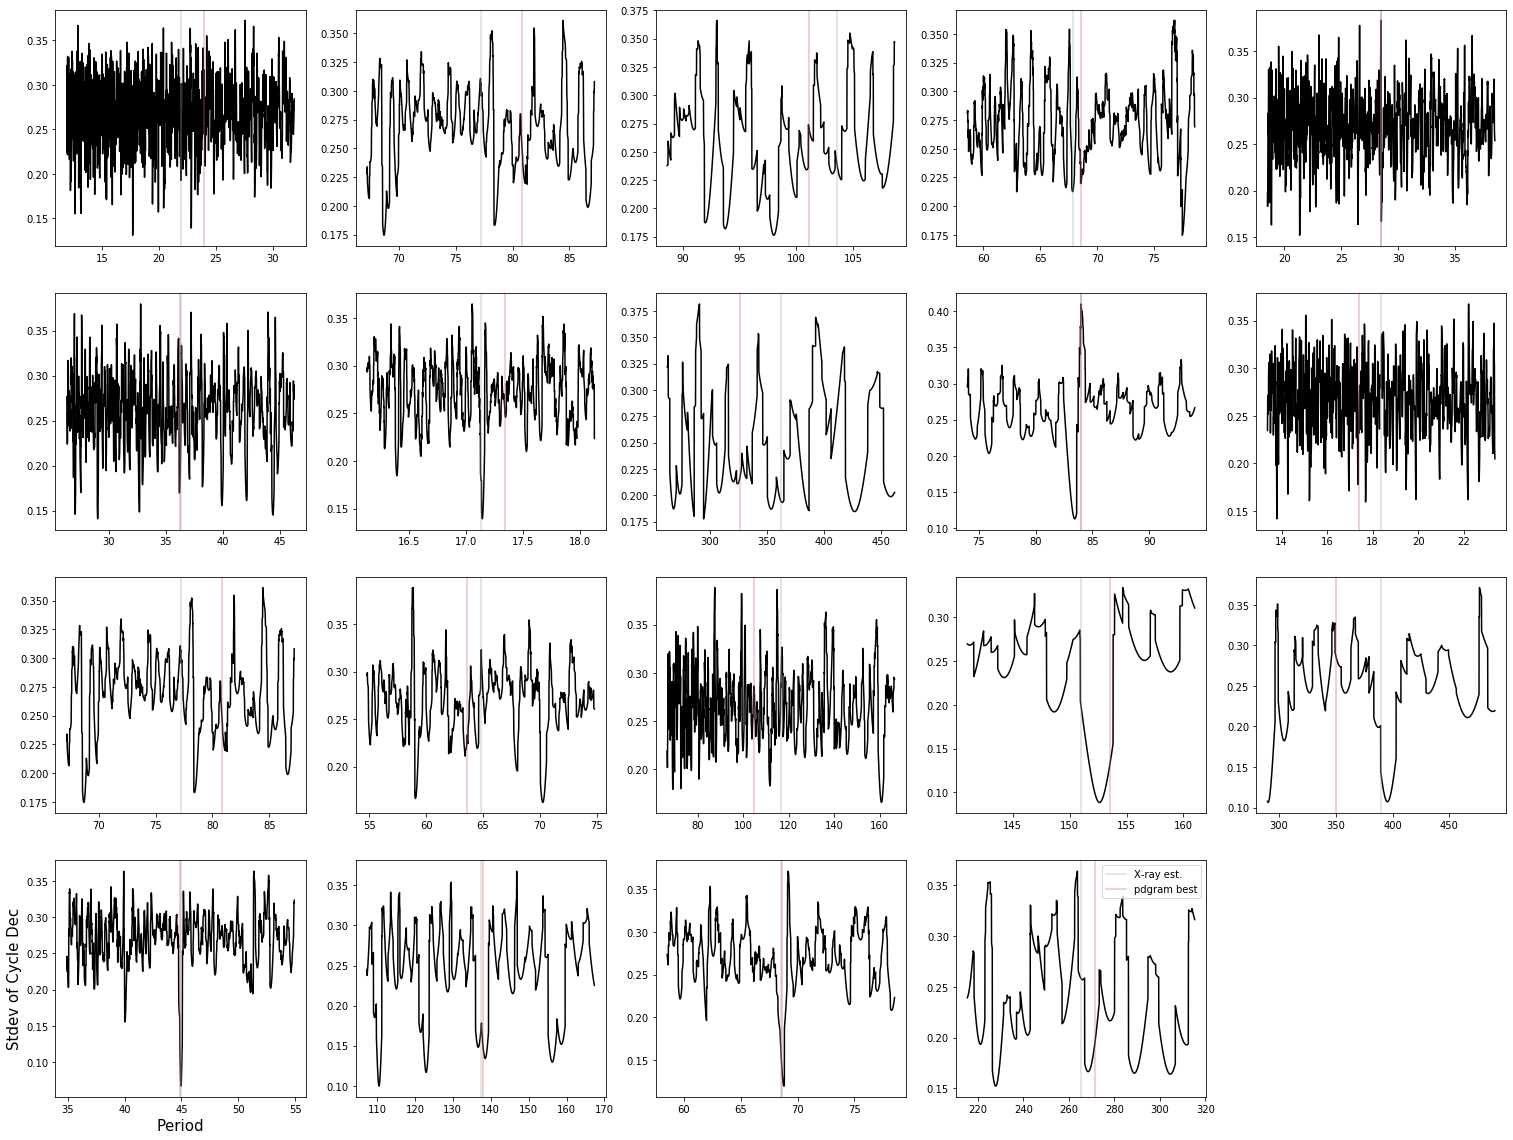

In [71]:
fig = plt.figure(figsize=(26,20))
c = 1
for x in xlist:
    src = str(int(x))
    periods = xdict[src][0]
    stds = xdict[src][1]
    ax = fig.add_subplot(4,5,c)
    est = xpers[c-1]
    auto = xopers[c-1]
    ax.plot(periods,stds,color='black')
    ax.axvline(est,color='darkseagreen',label='X-ray est.',alpha=0.4)
    ax.axvline(auto,color=pink,label='pdgram best',alpha=0.4)
    if x==xlist[-1]: ax.legend()
    if x==xlist[15]:
        ax.set_ylabel('Stdev of Cycle Dec',fontsize=15)
        ax.set_xlabel('Period',fontsize=15)
    c+=1
# sf('XrayToA')

In [72]:
np.savez('XrayToAs', xdict)

# Analyze ToAs for Remaining Sources, Looking out for Interesting Sources from PeriodbyYear Notebook
- may want to first fix the sampling

In [33]:
srcs = np.array(alls['src_n'])

In [15]:
srcs[:5]

array([2, 3, 4, 5, 6])

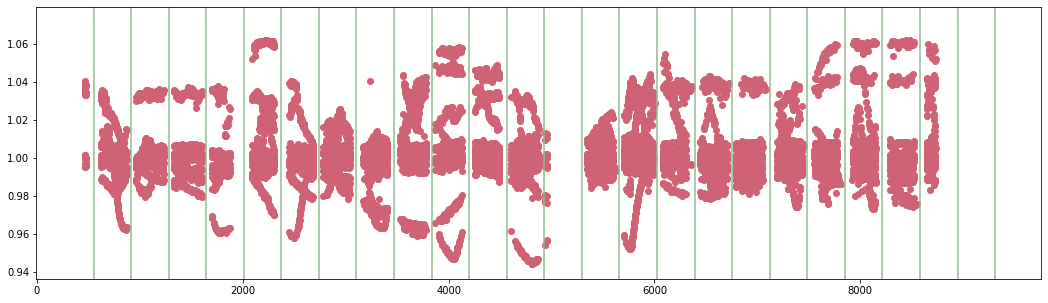

In [22]:
#grab a bunch of LCs and plot the points to look for gaps
plt.figure(figsize=(18,5))

for s in range(20):
    num = srcs[s]
    try:iband = o.getIV(num,cross,stack=True,both=False,plot=False)
    except:iband = o.getIV(num,cross2,mlist=mlist2,stack=True,both=False,plot=False) 
    #normalize
    iband['I mag'] /= np.median(iband['I mag'])
    plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink)
for i in range(25):
    plt.axvline(550+365*i,color='darkseagreen')

### so can try out always starting chunks at 550 days (in MJD-50000) to not have gaps in the middle of years
- for now going to continue but option to try out given more time

In [25]:
srcs[2] in xlist

False

4


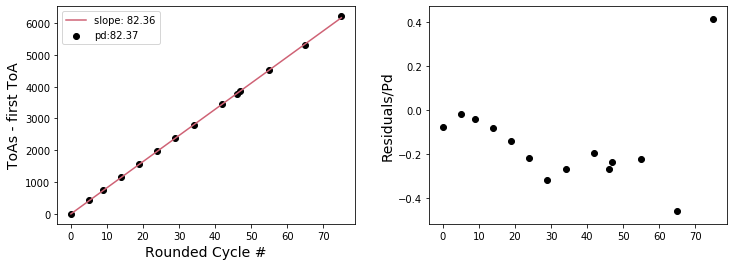

In [32]:
#first two already done above
src = srcs[2]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)

est: 82.37, best: 81.89


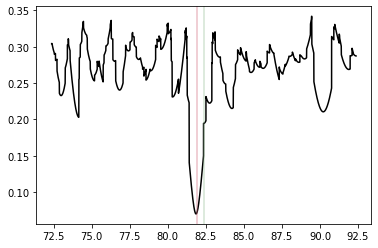

In [30]:
minp = toaloop(toas,pd-10,pd+10,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

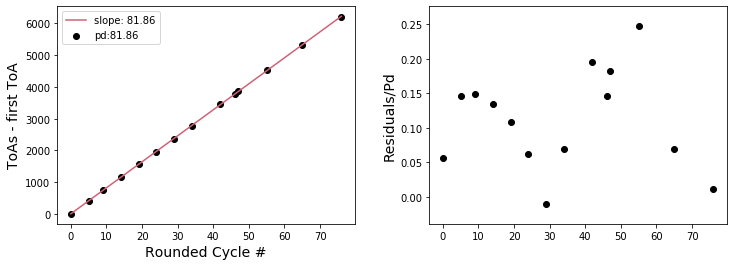

In [31]:
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,minp)

5


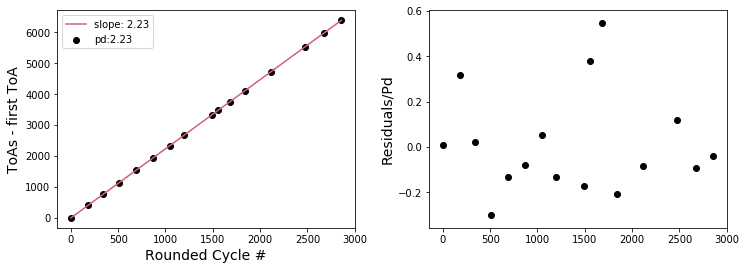

In [35]:
src = srcs[3]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)

est: 0.0, best: 2.23


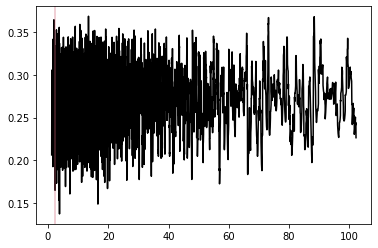

In [37]:
minp = toaloop(toas,pd-1,pd+100,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

8


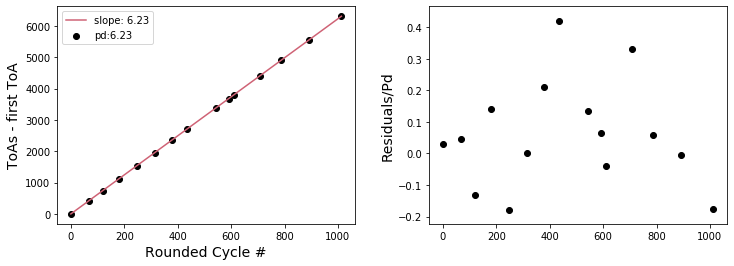

In [43]:
src = srcs[6]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)

est: 0.0, best: 6.23


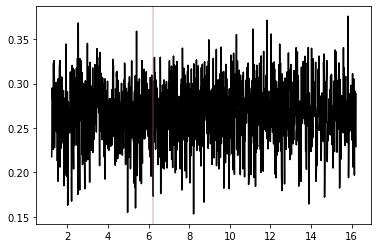

In [44]:
minp = toaloop(toas,pd-5,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

classified as aperiodic but slope matches best period

10


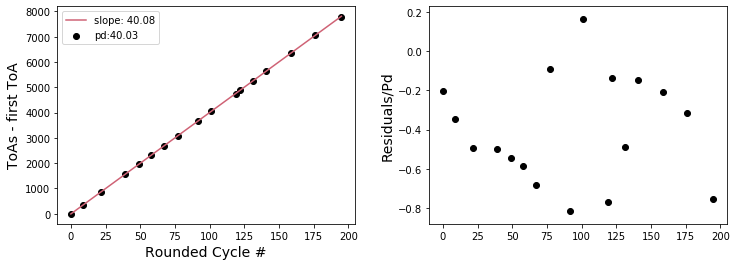

In [48]:
src = srcs[8]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)

est: 40.03, best: 39.83


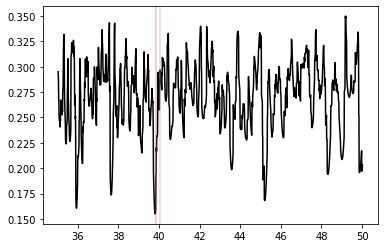

In [49]:
minp = toaloop(toas,pd-5,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

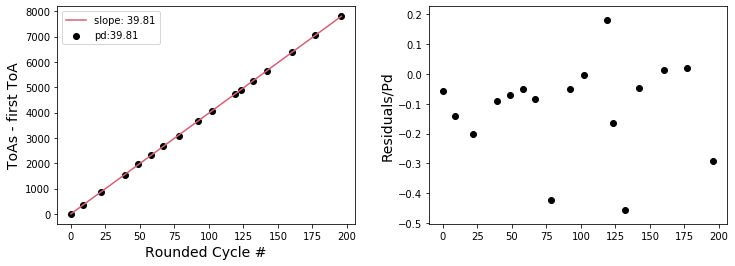

In [52]:
res(toas,39.81)

14


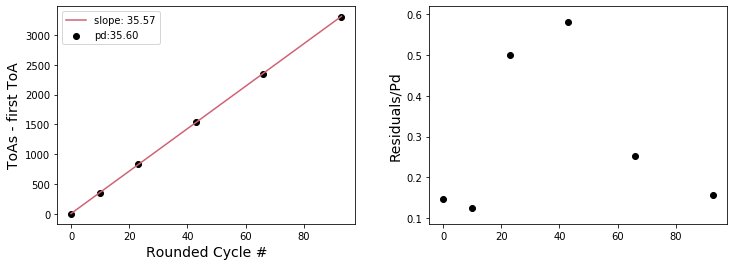

In [60]:
src = srcs[12]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)

est: 35.6, best: 35.62


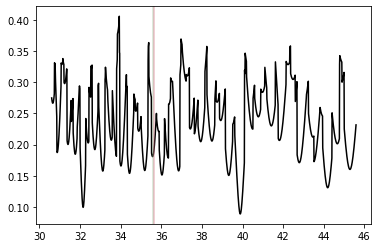

In [62]:
#doesn't have great baseline; absolute min not necessarily better with residuals
minp = toaloop(toas,pd-5,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

15
False


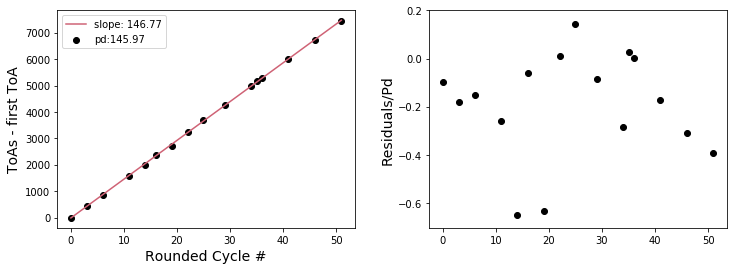

In [66]:
src = srcs[13]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 145.97


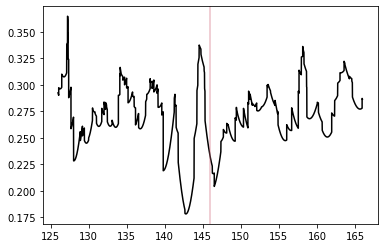

In [69]:
minp = toaloop(toas,pd-20,pd+20,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

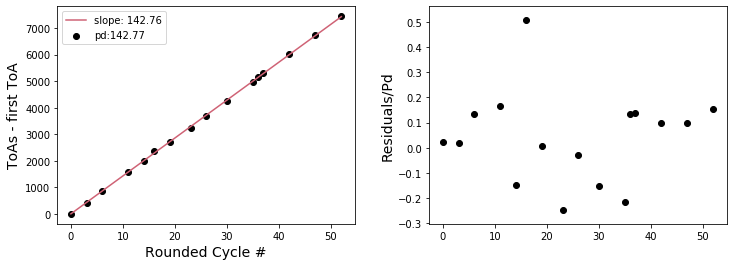

In [68]:
res(toas,minp)

16
False


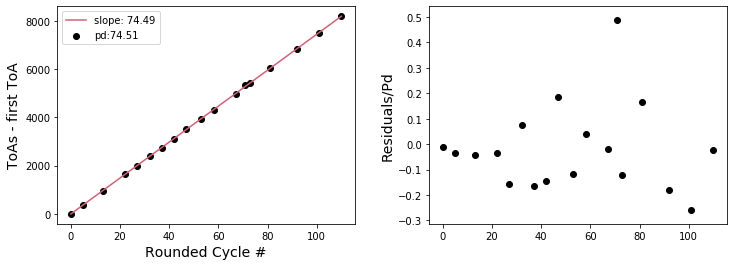

In [71]:
src = srcs[14]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 74.51, best: 74.30


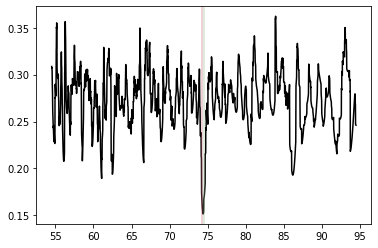

In [74]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

17
False


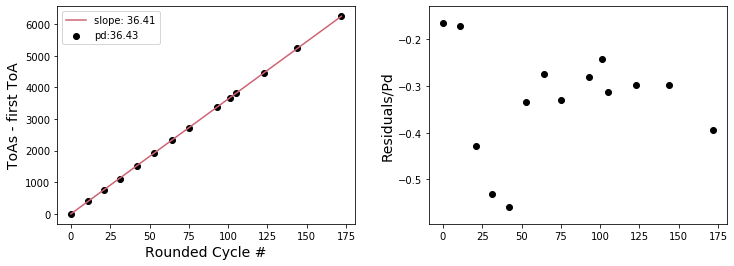

In [75]:
src = srcs[15]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 36.43182, best: 36.43


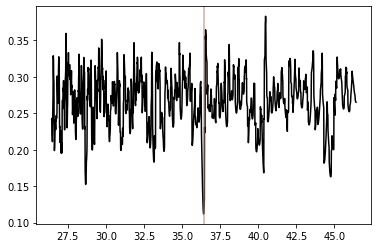

In [77]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

19
False


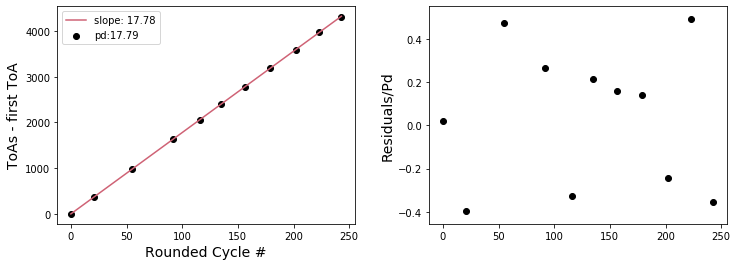

In [78]:
src = srcs[16]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 17.79, best: 17.91


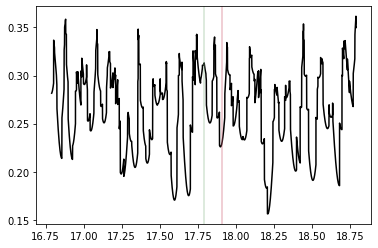

In [83]:
minp = toaloop(toas,pd-1,pd+1,0.0001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

20
False


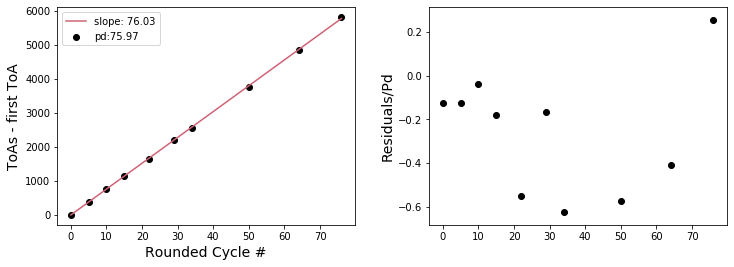

In [84]:
src = srcs[17]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 75.97, best: 83.36


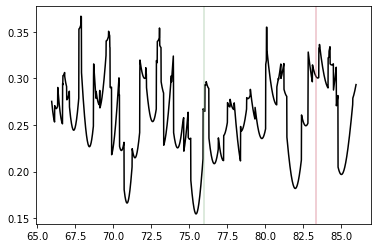

In [85]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

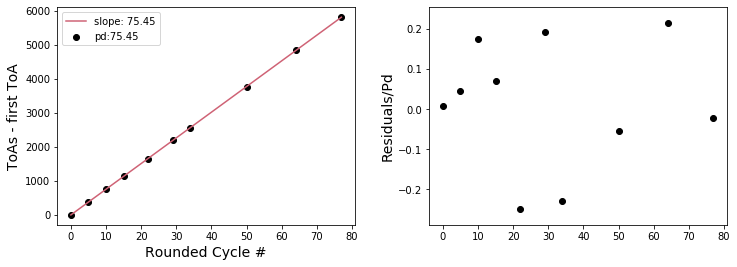

In [86]:
res(toas,minp)

ToA absolute min looks better than best and est.

21
False


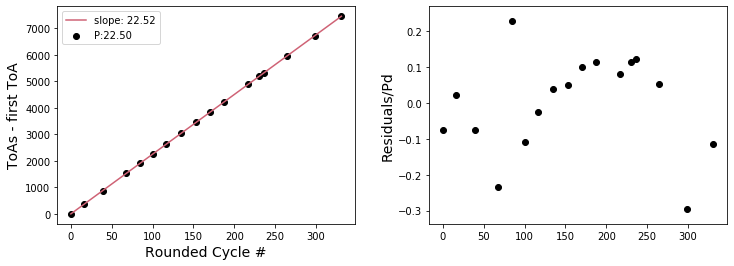

In [99]:
src = srcs[18]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 22.5, best: 22.51


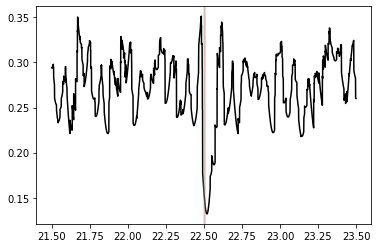

In [89]:
minp = toaloop(toas,pd-1,pd+1,0.0001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

In [92]:
# res(toas,minp)

22
False


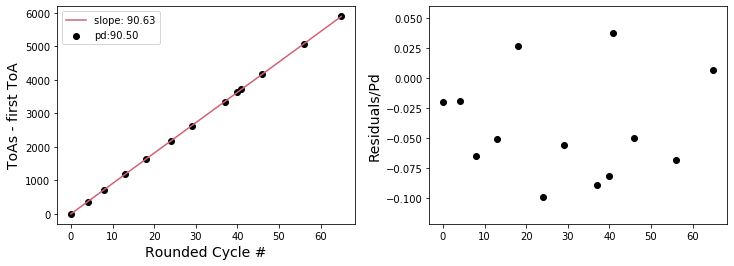

In [91]:
src = srcs[19]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 90.5, best: 90.44


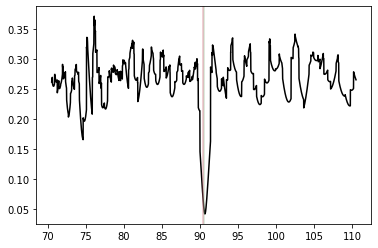

In [93]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

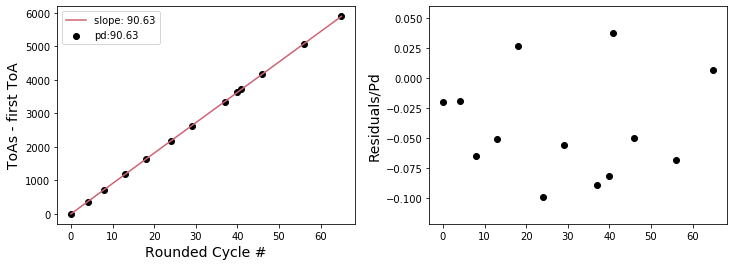

In [95]:
res(toas,minp) #basically the same

24
False


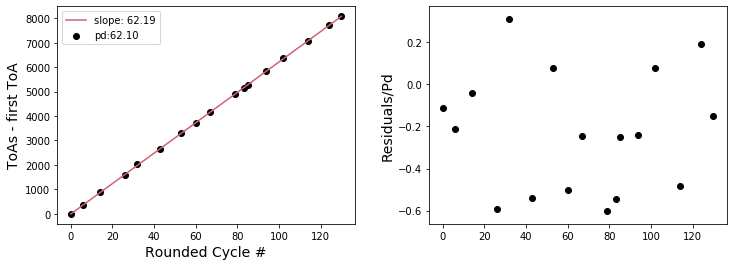

In [111]:
src = srcs[21]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 62.1, best: 60.91


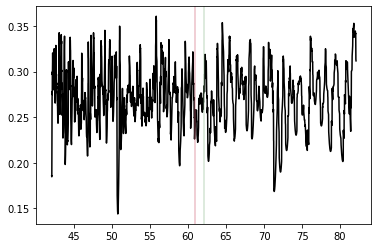

In [112]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

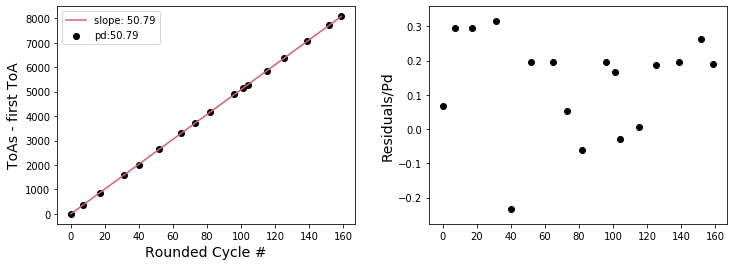

In [113]:
res(toas,minp)

50.78999999999827 69.86999999999702


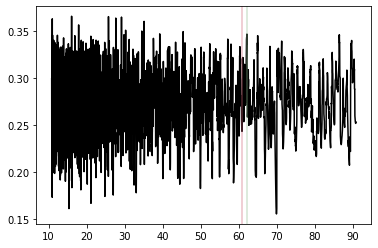

In [115]:
#re-fold with other min --> doesn't persist
toas,pd = yearloop(src,minp,mult=1,findpd='no',retpd=True)
minp2 = toaloop(toas,pd-40,pd+40,0.01,color='black',retbest=True)
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
print(minp,minp2)

25
empty file for OIII I
False


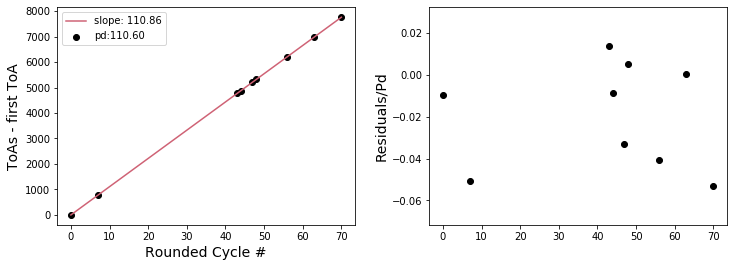

In [218]:
src = srcs[22]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 110.6, best: 110.85


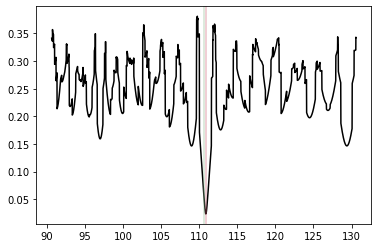

In [219]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

26
False


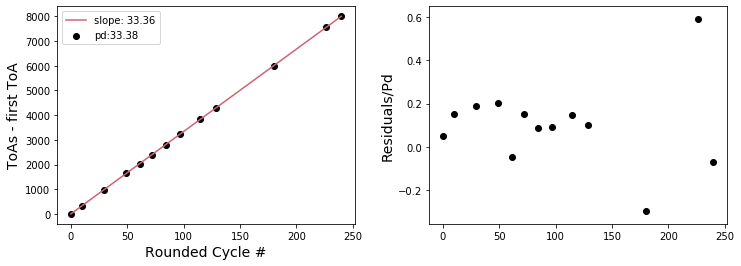

In [121]:
src = srcs[23]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 33.38, best: 33.41


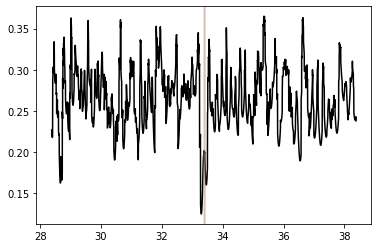

In [123]:
minp = toaloop(toas,pd-5,pd+5,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

28
False


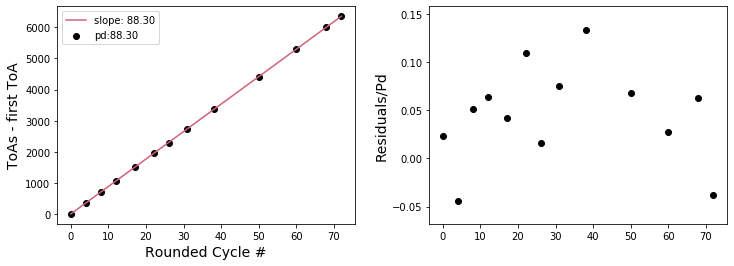

In [221]:
src = srcs[25]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 88.3, best: 88.34


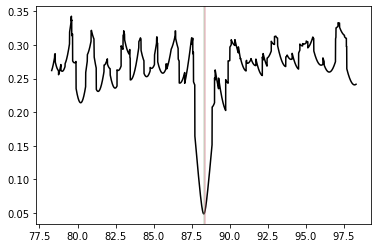

In [222]:
#so nice!
minp = toaloop(toas,pd-10,pd+10,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

30
False


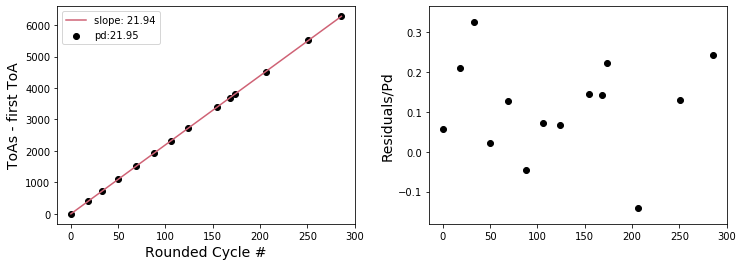

In [157]:
src = srcs[26]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 21.95, best: 21.96


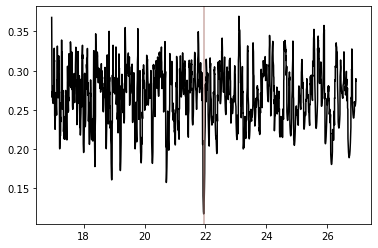

In [159]:
minp = toaloop(toas,pd-5,pd+5,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

32
False


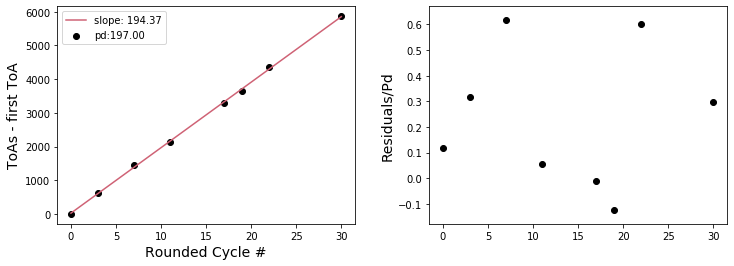

In [225]:
src = srcs[28]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 197.0, best: 185.99


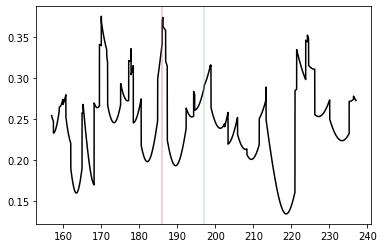

In [226]:
minp = toaloop(toas,pd-40,pd+40,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 197.0, best: 185.99


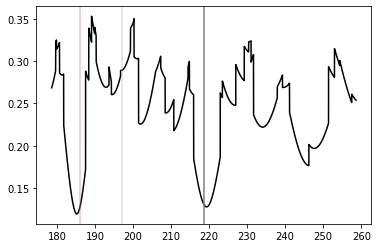

In [228]:
#re-fold with best period above and see if same period comes out
toas,pd = yearloop(src,minp,mult=2,findpd='no',retpd=True)
minp2 = toaloop(toas,minp-40,minp+40,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
plt.axvline(minp,color='grey')
print(f'est: {est}, best: {best:.2f}')

34
False


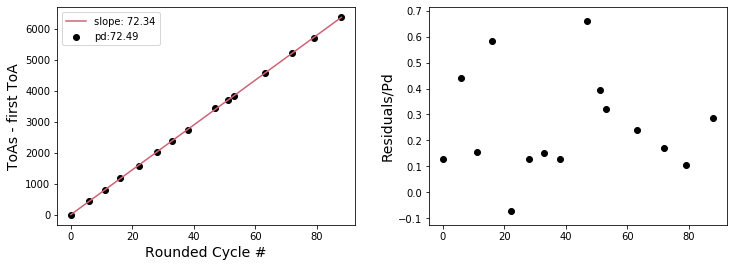

In [181]:
src = srcs[29]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 72.49


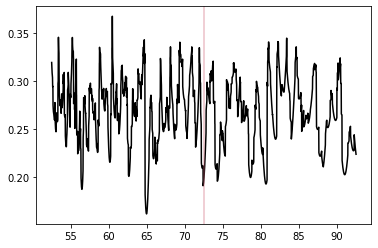

In [182]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 72.49


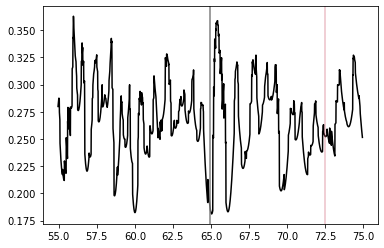

In [184]:
#re-fold and see if best period maintained
toas,pd = yearloop(src,minp,mult=1,findpd='no',retpd=True)
minp2 = toaloop(toas,minp-10,minp+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
plt.axvline(minp,color='grey')
print(f'est: {est}, best: {best:.2f}')

#### may want to pursue this lower period, but periodograms by year very complicated

35
False


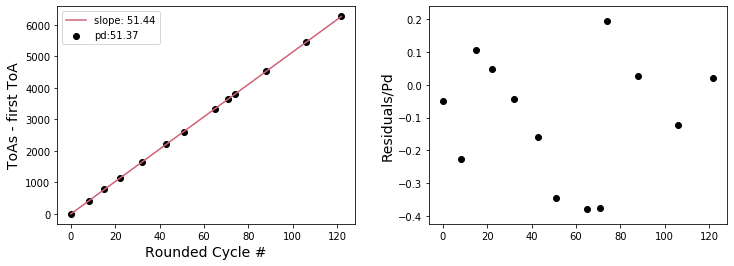

In [229]:
src = srcs[30]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 51.37


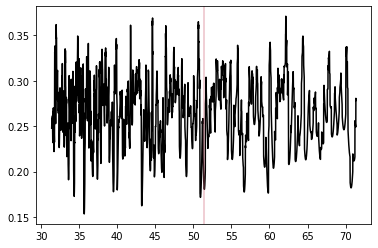

In [230]:
#had imperfect phase stability with this period
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

38
False


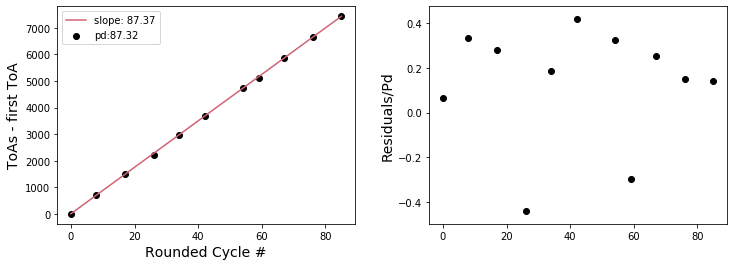

In [236]:
src = srcs[33]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 87.32


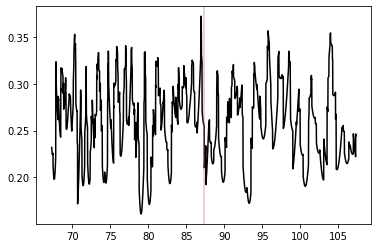

In [237]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

39
False


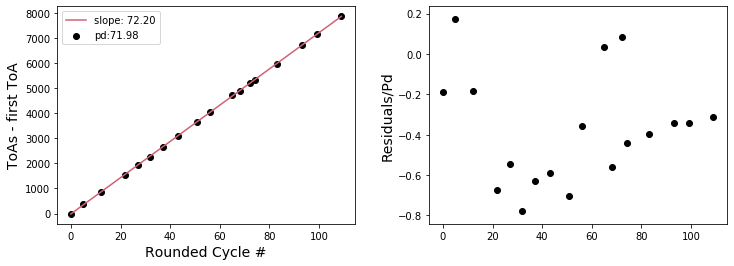

In [241]:
#phase-folds don't have great stability for either period
src = srcs[34]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 71.98, best: 72.33


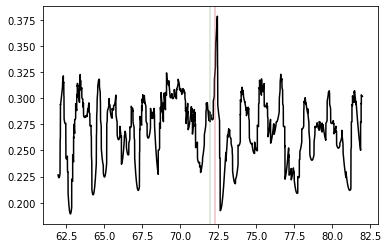

In [243]:
minp = toaloop(toas,pd-10,pd+10,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

40
False


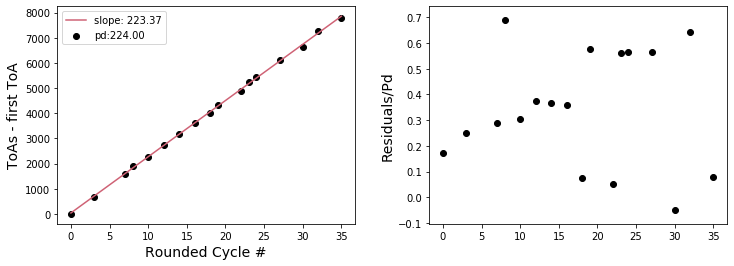

In [244]:
src = srcs[35]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 224.0, best: 225.81


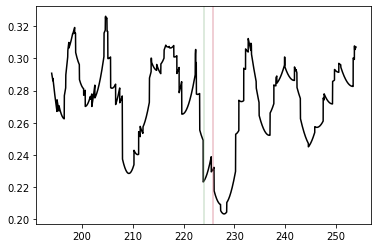

In [246]:
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

In [372]:
def refold(mult=1,search=10,step=0.01):
    '''
    repeat ToA procedure by folding using best period from first fold
    mult: number of years per chunk
    search: search with this radius from the period
    step: step size in days
    '''
    toas,pd = yearloop(src,minp,mult=mult,findpd='no',retpd=True)
    minp2 = toaloop(toas,minp-search,minp+search,step,color='black',retbest=True)
    row = alls[alls['src_n']==src]
    est = float(row['est. period'])
    best = float(row['best auto det pd'])
    if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
    plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')
    plt.axvline(minp,color='grey',label='best from first fold')
    plt.legend()
    print(f'est: {est}, best: {best:.2f}')
    print(f'new best: {minp2:.2f}')

est: 224.0, best: 225.81


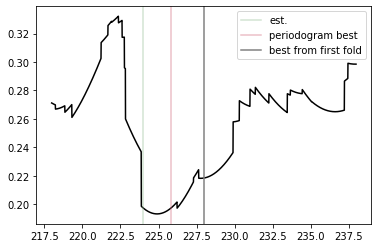

In [249]:
#re-fold to see if best maintained
refold(search=30)

41
False


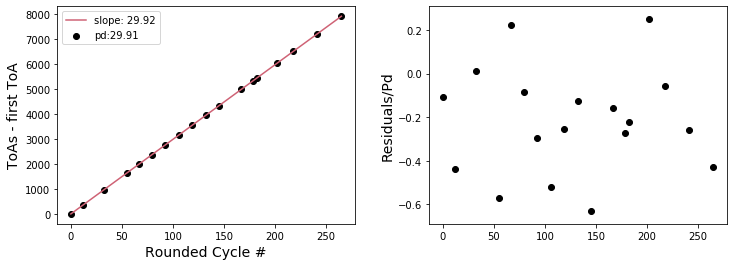

In [250]:
src = srcs[36]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 29.91, best: 29.90


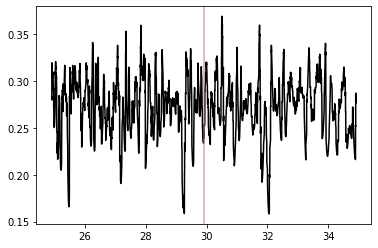

In [257]:
minp = toaloop(toas,pd-5,pd+5,0.0001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 29.91, best: 29.90
new best: 31.86


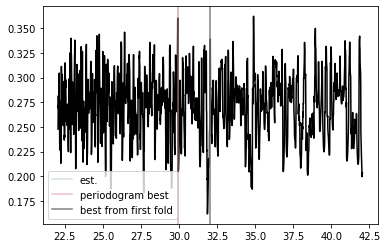

In [258]:
refold()

42
False


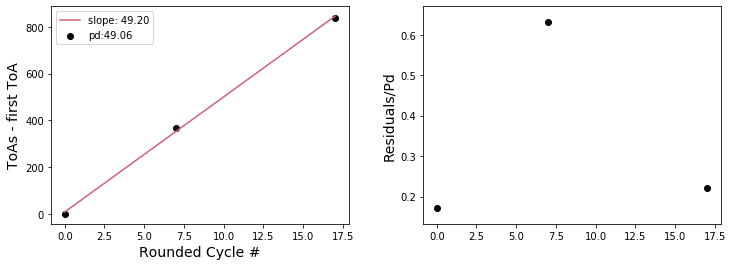

In [259]:
src = srcs[37]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

45
False


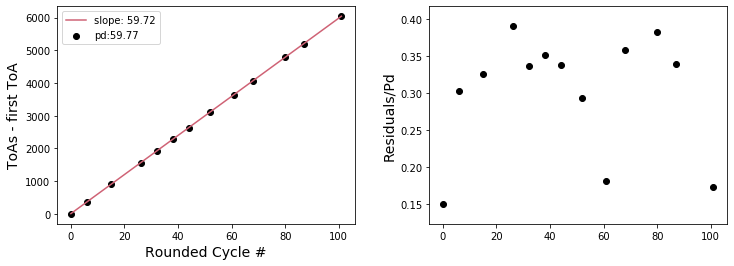

In [263]:
src = srcs[39]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 59.77, best: 59.71


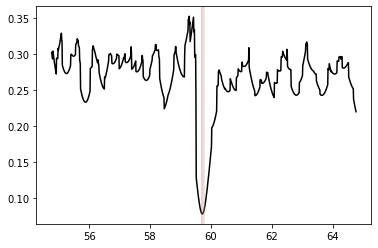

In [265]:
#and one of the best phase-folds
minp = toaloop(toas,pd-5,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

46
False


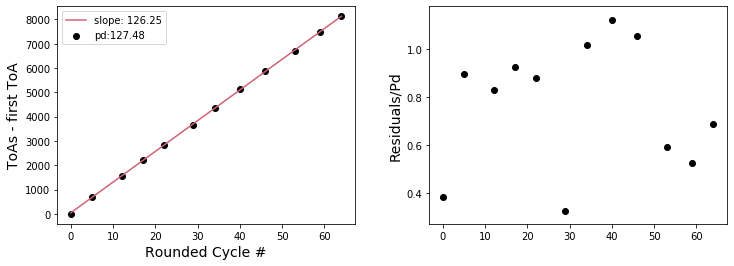

In [280]:
src = srcs[40]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 127.48


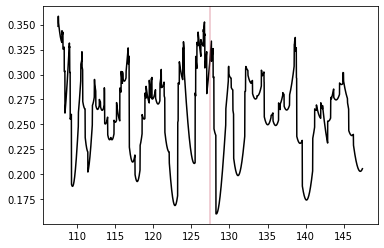

In [281]:
#not super trustworthy
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 127.48
new best: 128.59


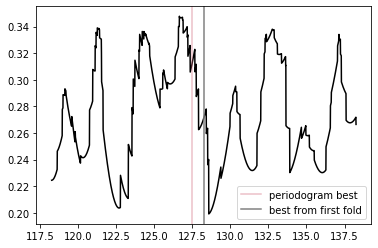

In [271]:
refold()

50
False


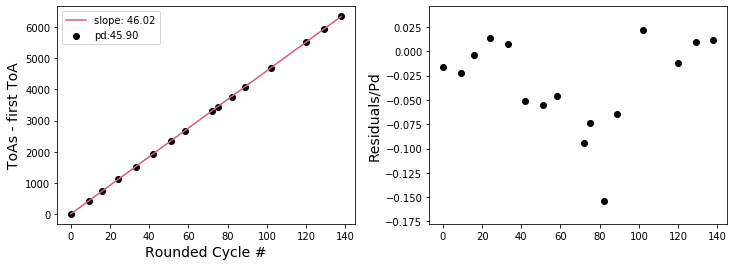

In [282]:
src = srcs[44]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 45.9, best: 45.95


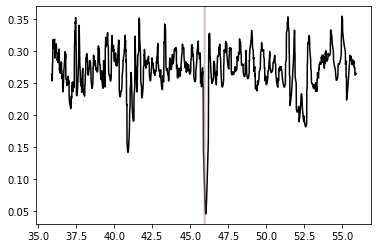

In [283]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

52
False


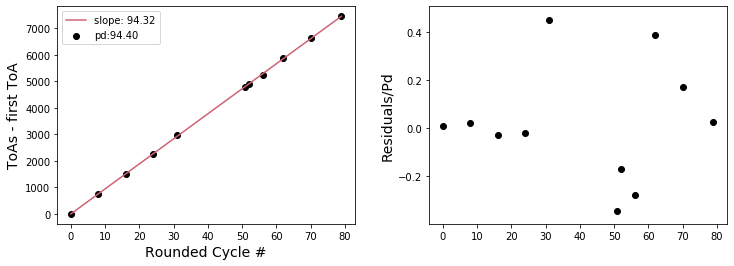

In [288]:
src = srcs[46]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 94.4, best: 100.62


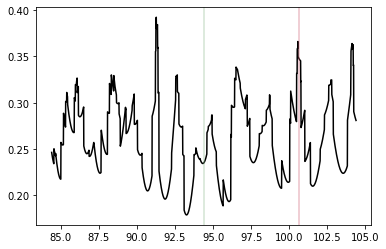

In [289]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 94.4, best: 100.62
new best: 86.99


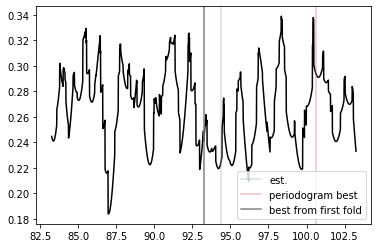

In [290]:
refold()

53
False


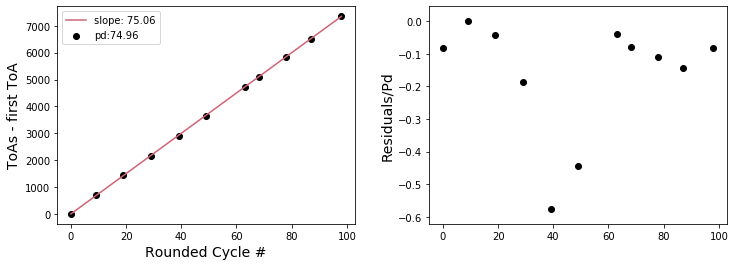

In [291]:
src = srcs[47]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 74.96, best: 74.02


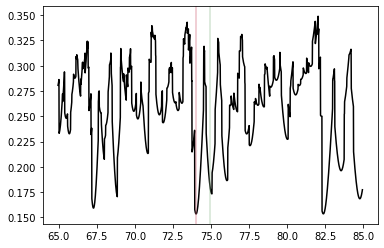

In [292]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 74.96, best: 74.02
new best: 74.17


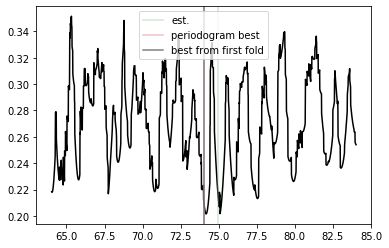

In [293]:
refold()

55
False


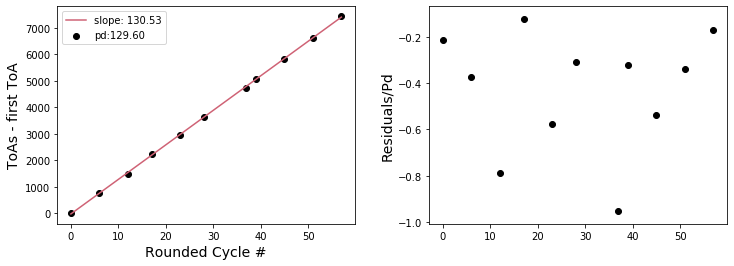

In [295]:
src = srcs[49]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 129.60


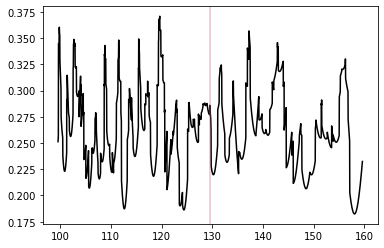

In [297]:
#not sufficiently good
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

56
True


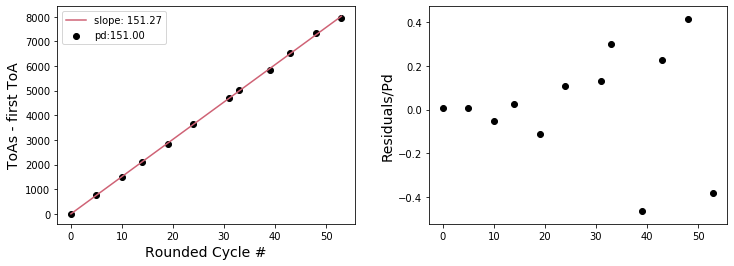

In [298]:
src = srcs[50]
print(src)
toas,pd = yearloop(src,0,mult=2,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 151.0, best: 153.51


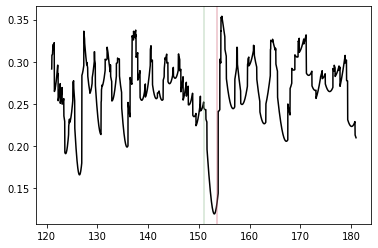

In [299]:
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 151.0, best: 153.51
new best: 152.97


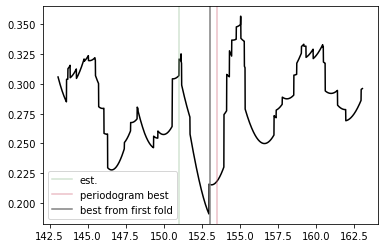

In [300]:
refold()

57
False


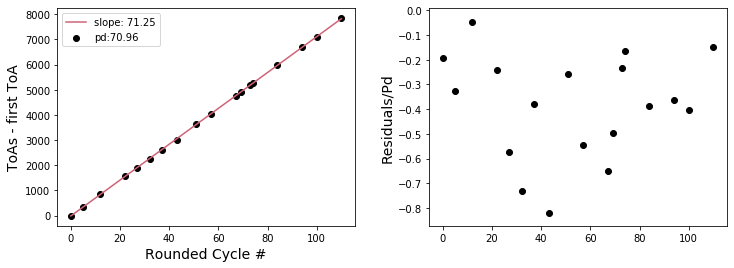

In [303]:
src = srcs[51]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 70.96


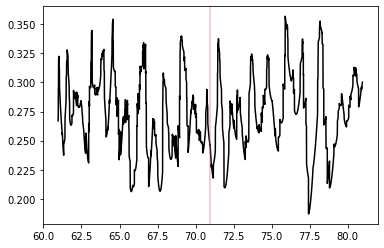

In [305]:
minp = toaloop(toas,pd-10,pd+10,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

58
False


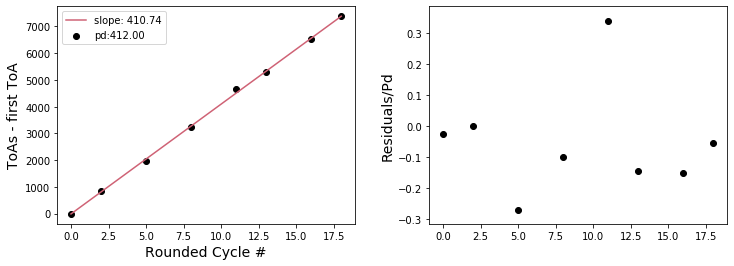

In [314]:
src = srcs[52]
print(src)
toas,pd = yearloop(src,0,mult=3,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 412.0, best: 411.76


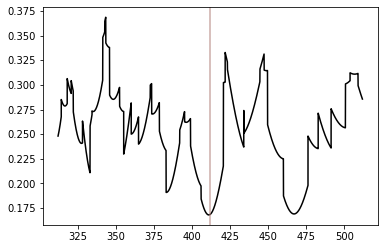

In [315]:
#works better when not detrended
minp = toaloop(toas,pd-100,pd+100,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

59
False


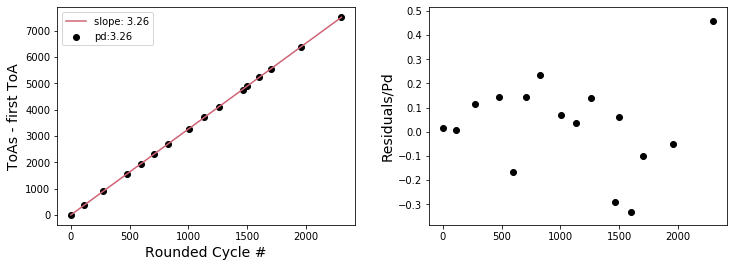

In [318]:
src = srcs[53]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True)
res(toas,pd)
print(src in xlist)

61
False


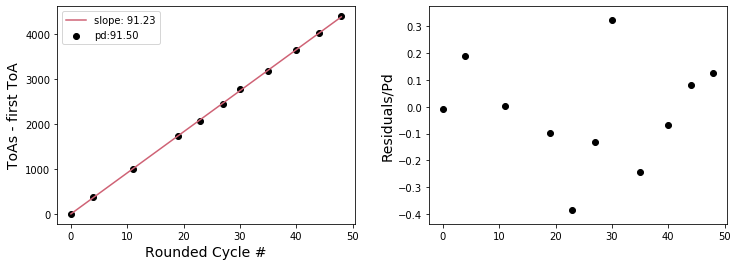

In [332]:
src = srcs[55]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 91.5, best: 90.87


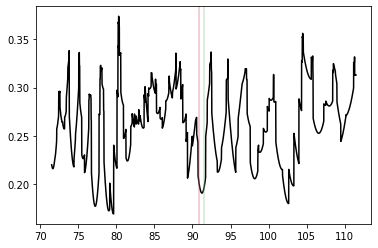

In [333]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

62
False


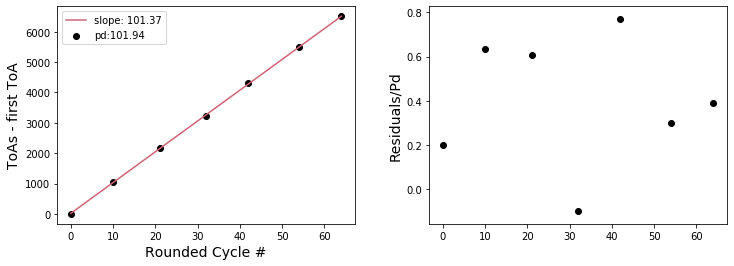

In [336]:
src = srcs[56]
print(src)
toas,pd = yearloop(src,0,mult=3,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 101.94, best: 102.11


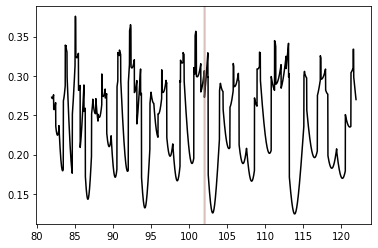

In [337]:
#different depending on whether or not mult 2 or 3 used
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

64
False


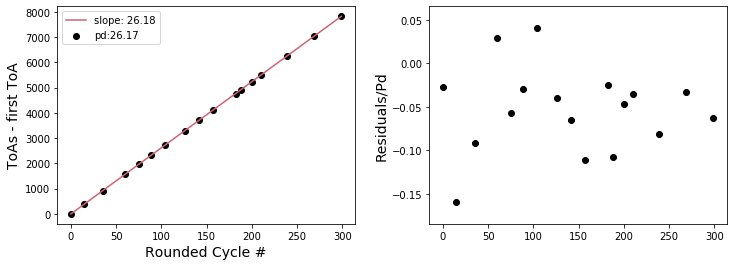

In [343]:
src = srcs[58]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 26.17


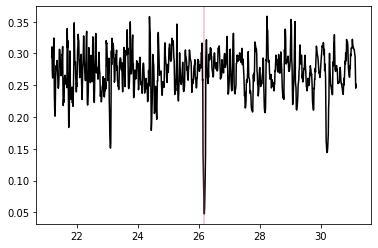

In [345]:
#beautiful
minp = toaloop(toas,pd-5,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

65
False


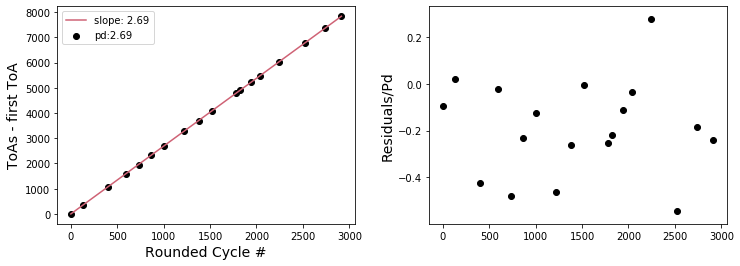

In [347]:
src = srcs[59]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 2.69


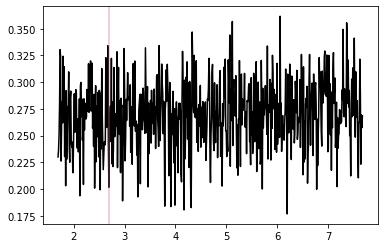

In [349]:
minp = toaloop(toas,pd-1,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

67
False


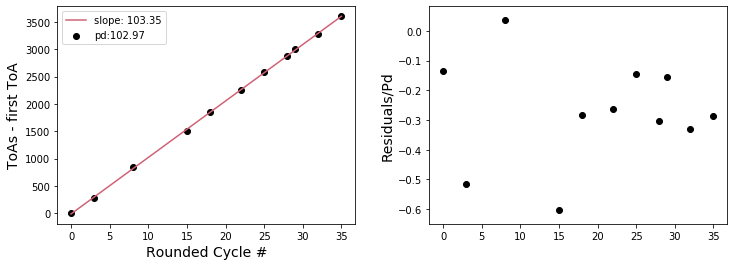

In [356]:
src = srcs[60]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 102.97


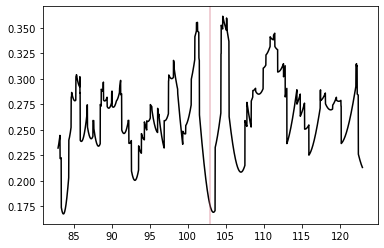

In [357]:
#decent possibility
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

68
False


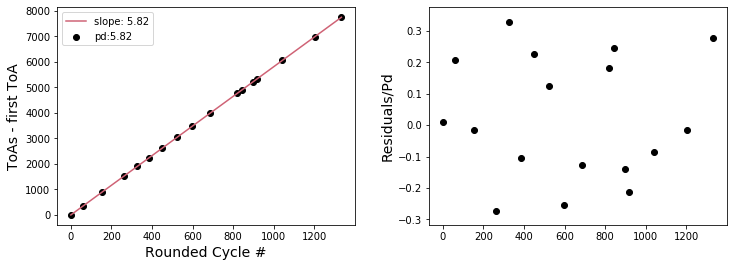

In [360]:
src = srcs[61]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

69
False


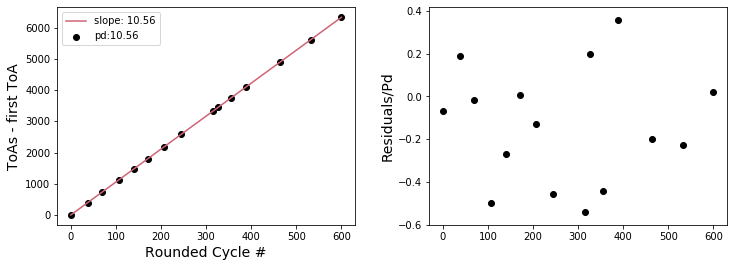

In [362]:
src = srcs[62]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

71
False


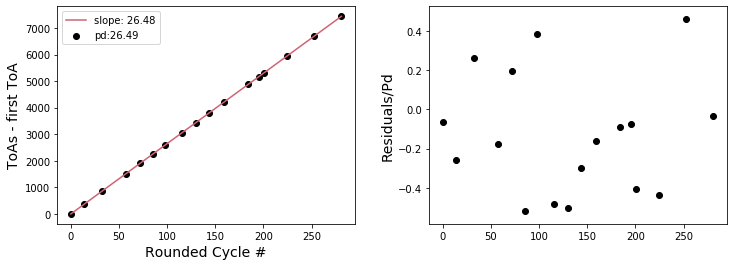

In [364]:
src = srcs[63]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

72
False


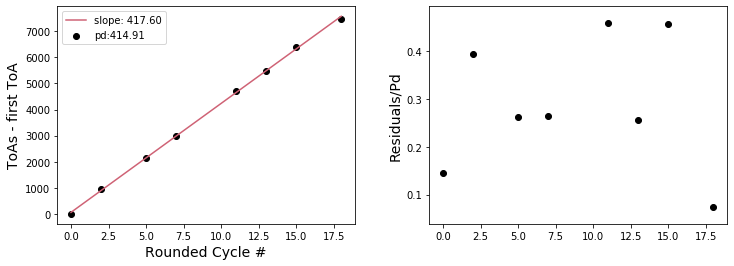

In [367]:
src = srcs[64]
print(src)
toas,pd = yearloop(src,0,mult=3,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 414.91345, best: 416.53


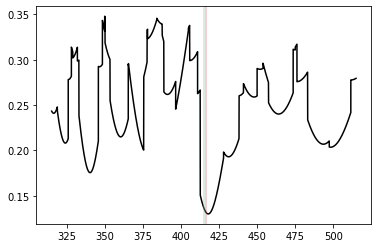

In [369]:
minp = toaloop(toas,pd-100,pd+100,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 414.91345, best: 416.53
new best: 379.74


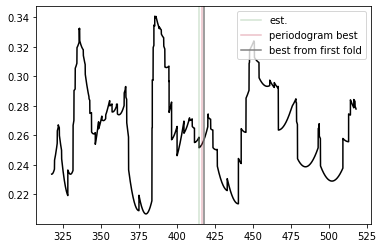

In [373]:
refold(search=100)

73
False


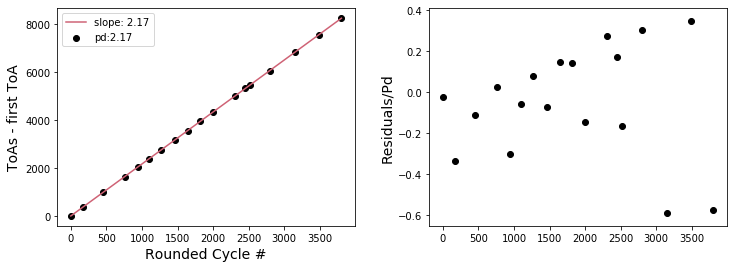

In [375]:
src = srcs[65]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 2.17


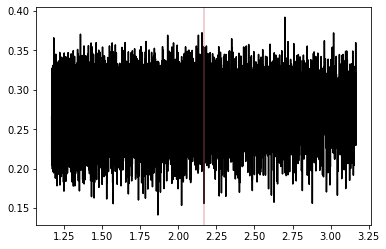

In [378]:
minp = toaloop(toas,pd-1,pd+1,0.0001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

75
False


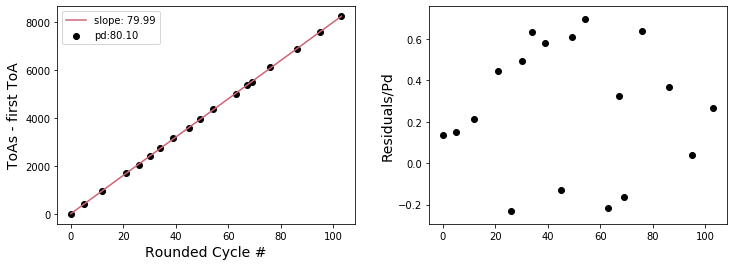

In [395]:
src = srcs[66]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 80.1, best: 80.79


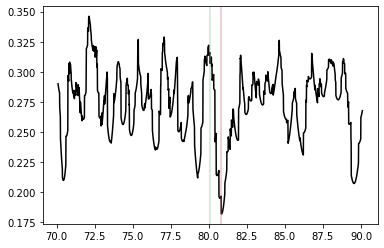

In [396]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 80.1, best: 80.79
new best: 77.70


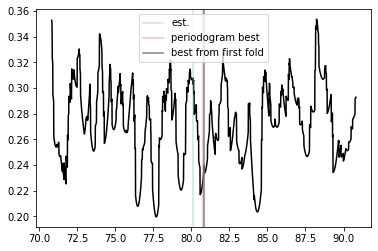

In [397]:
refold()

76
False


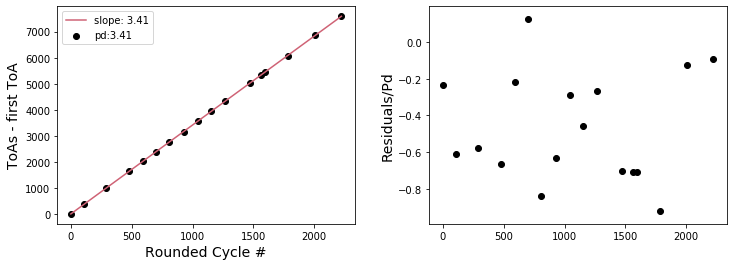

In [393]:
src = srcs[67]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 3.41


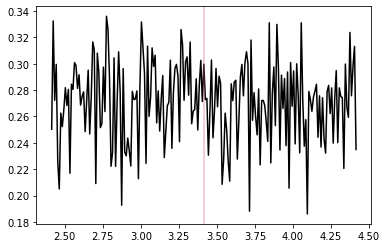

In [394]:
minp = toaloop(toas,pd-1,pd+1,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

In [387]:
# refold(search=1)

77
False


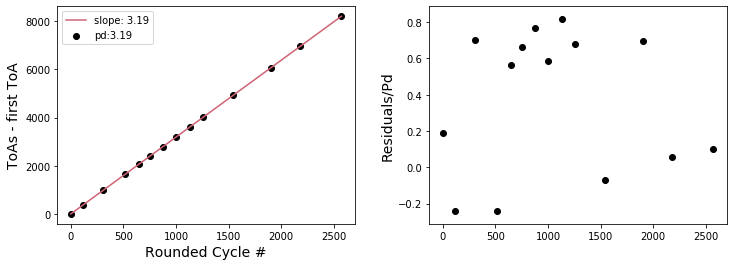

In [391]:
src = srcs[68]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 3.19


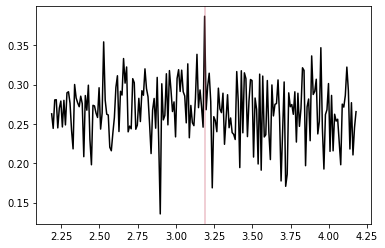

In [392]:
minp = toaloop(toas,pd-1,pd+1,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

78
empty file for OII I
False


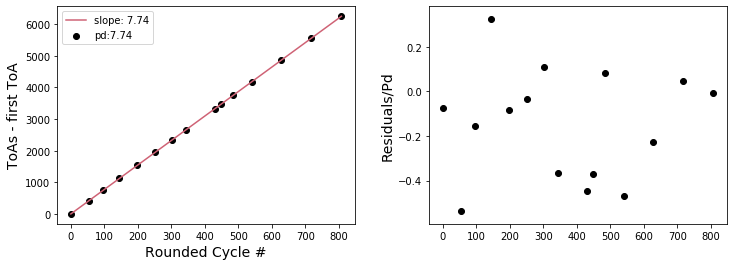

In [398]:
src = srcs[69]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 7.74


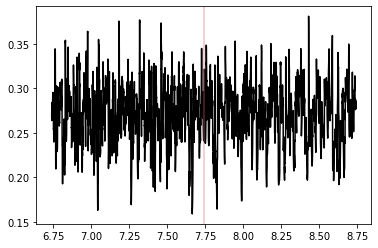

In [400]:
minp = toaloop(toas,pd-1,pd+1,0.0001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

79
False


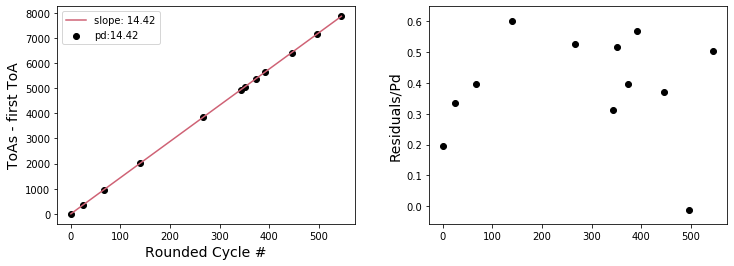

In [401]:
src = srcs[70]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 14.42


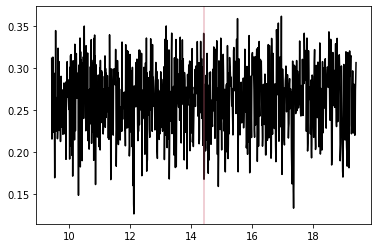

In [402]:
minp = toaloop(toas,pd-5,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

80
False


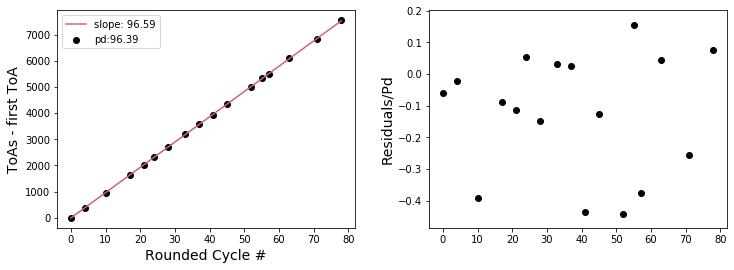

In [408]:
src = srcs[71]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 96.39


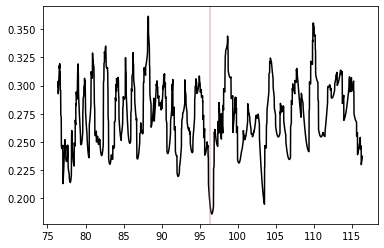

In [409]:
#more evience of this being a good new period
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 96.39
new best: 96.66


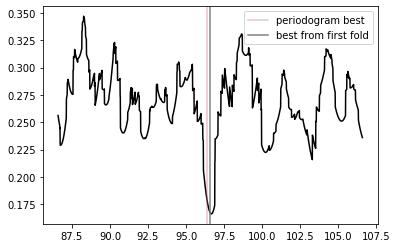

In [405]:
refold()

81
False


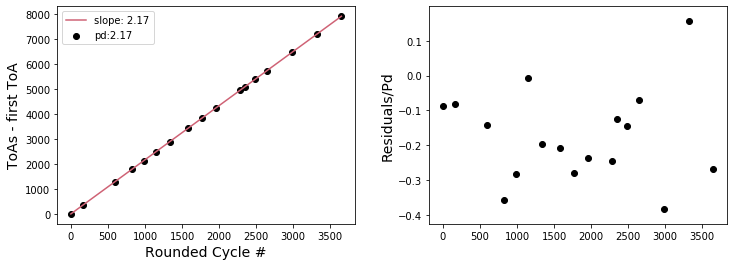

In [412]:
src = srcs[72]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 2.17


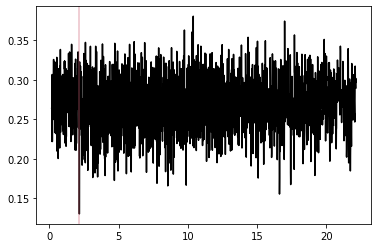

In [415]:
minp = toaloop(toas,pd-2,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

82
False


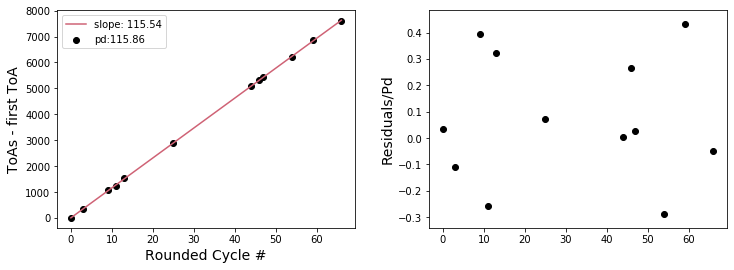

In [438]:
src = srcs[73]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 115.86


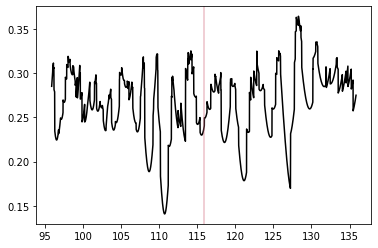

In [439]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

different other answers dependending on mult 1 or 2, but best auto det always in local min

est: 0.0, best: 115.86
new best: 110.76


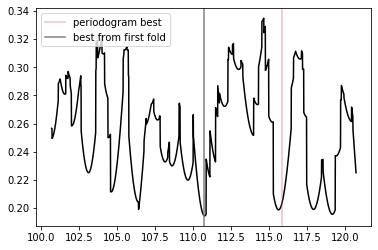

In [440]:
refold()

84
False


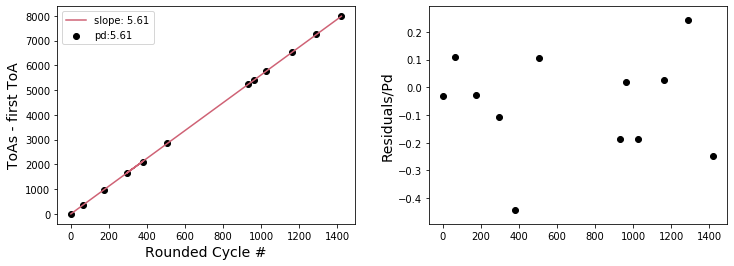

In [432]:
src = srcs[74]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

85
False


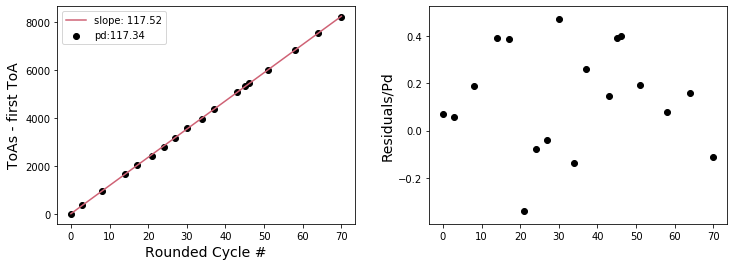

In [447]:
src = srcs[75]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 117.34


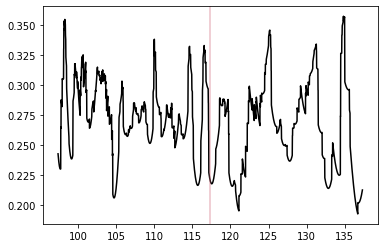

In [448]:
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

86
False


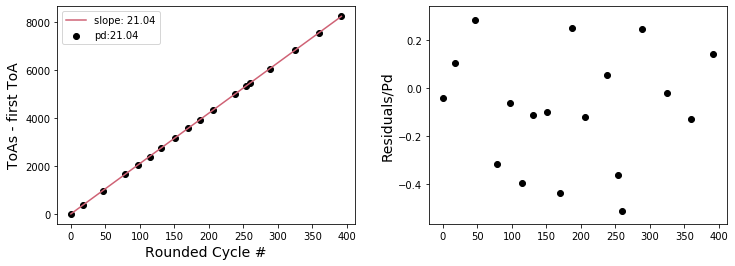

In [449]:
src = srcs[76]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 21.04


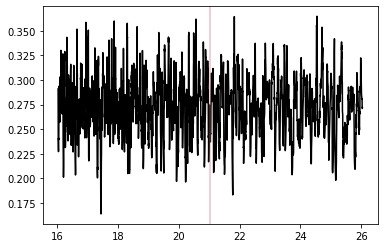

In [452]:
minp = toaloop(toas,pd-5,pd+5,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

87
False


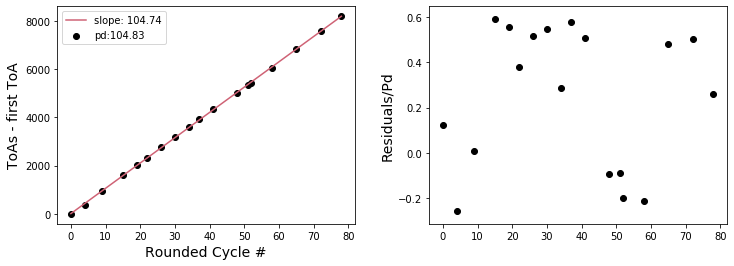

In [460]:
src = srcs[77]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 104.83


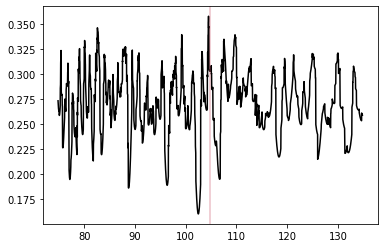

In [461]:
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 104.83
new best: 102.23


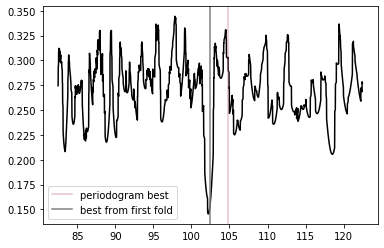

In [462]:
refold(search=20)

some nice consistency around 102 days

95
False


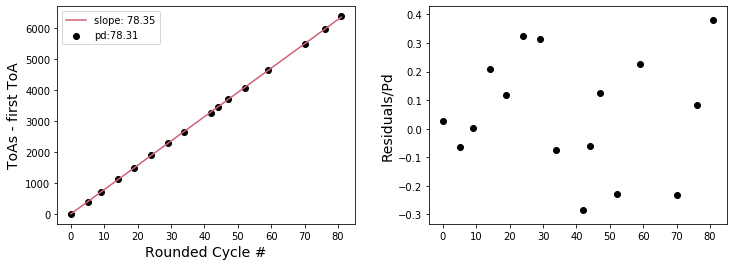

In [464]:
src = srcs[79]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist)

est: 0.0, best: 78.31


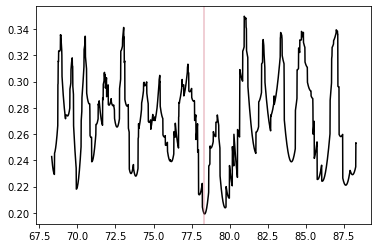

In [466]:
#only best this locally
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

96
False


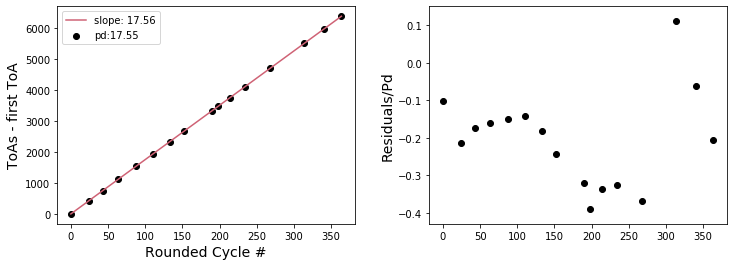

In [467]:
src = srcs[80]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) #interesting res pattern

est: 0.0, best: 17.55


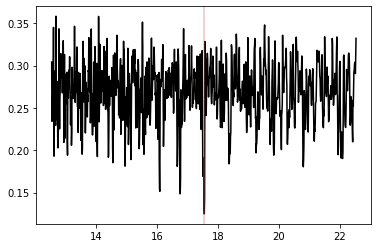

In [469]:
minp = toaloop(toas,pd-5,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

97
False


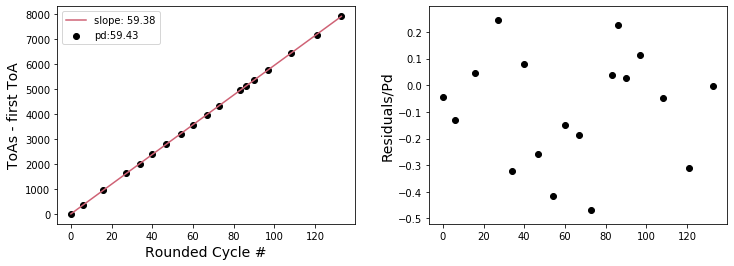

In [470]:
src = srcs[81]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 59.43


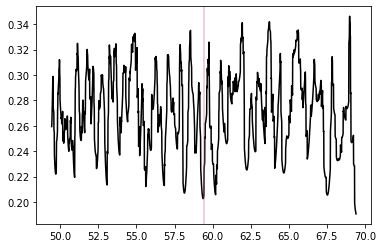

In [471]:
#some evidence
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

100
False


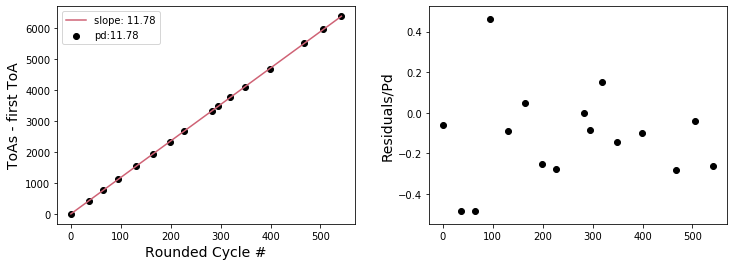

In [475]:
src = srcs[83]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

101
False


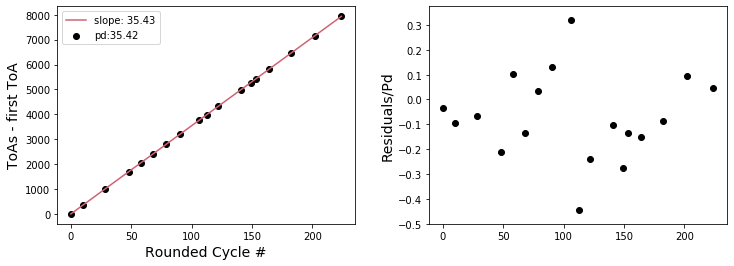

In [478]:
src = srcs[84]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 35.42


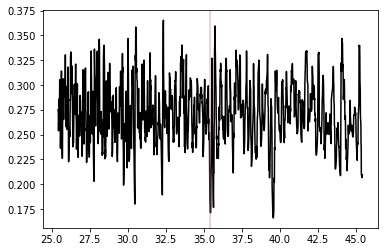

In [479]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 35.42
new best: 35.35


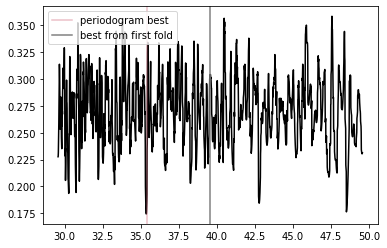

In [480]:
refold() #shows evidence for periodogram best period

104
False


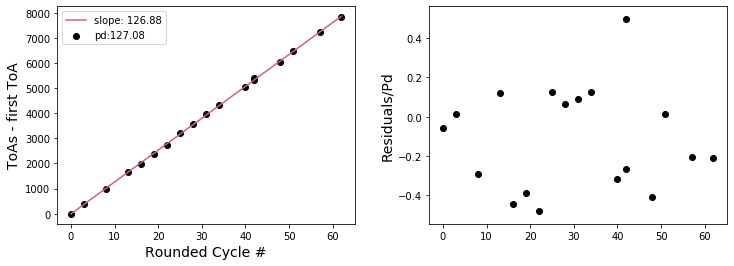

In [489]:
src = srcs[85]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 127.08


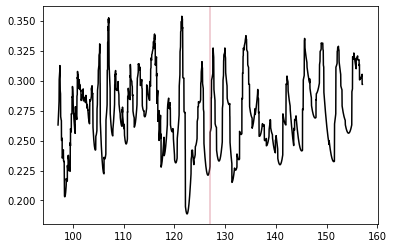

In [490]:
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 127.08
new best: 128.69


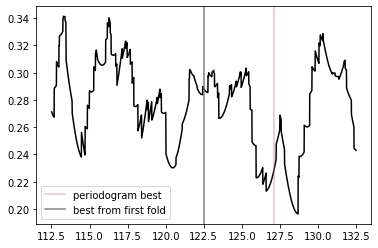

In [491]:
refold()

105
False


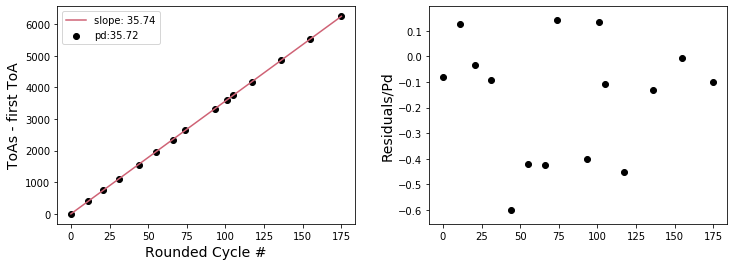

In [492]:
src = srcs[86]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

106
False


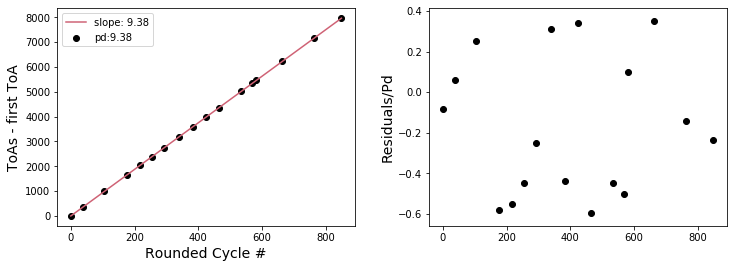

In [495]:
src = srcs[87]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 9.38


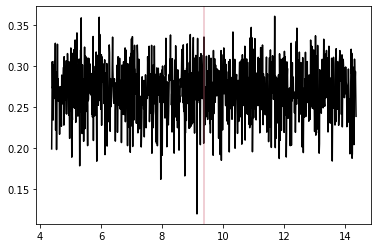

In [496]:
minp = toaloop(toas,pd-5,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 9.38
new best: 4.83


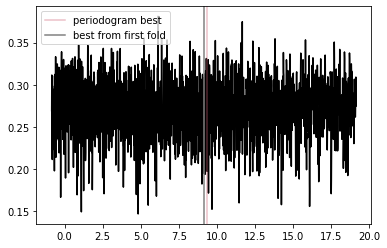

In [497]:
refold()

111
False


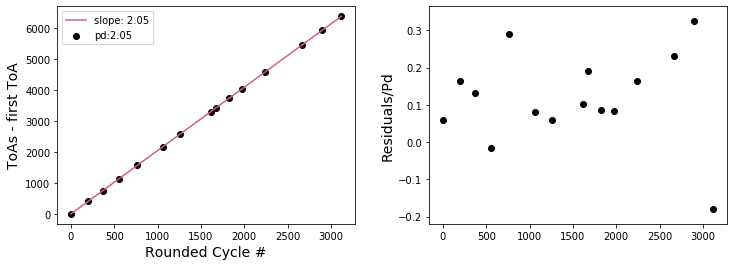

In [502]:
src = srcs[89]
print(src)
toas,pd = yearloop(src,0,mult=0.5,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 2.05


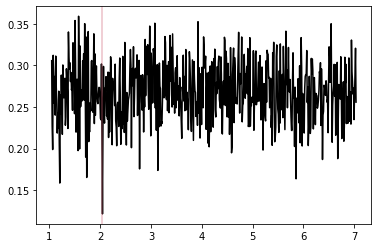

In [503]:
minp = toaloop(toas,pd-1,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

114
False


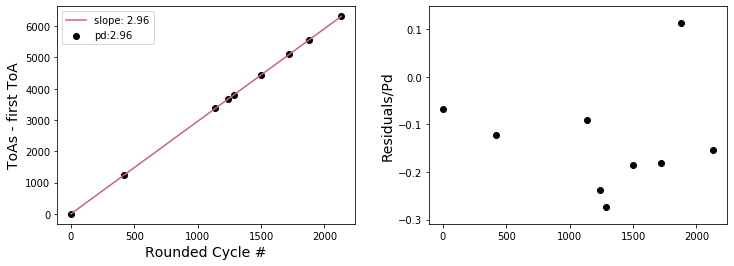

In [505]:
src = srcs[90]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

115
False


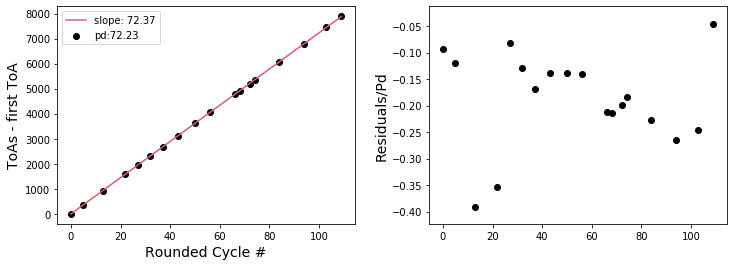

In [508]:
src = srcs[91]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 72.231, best: 72.30


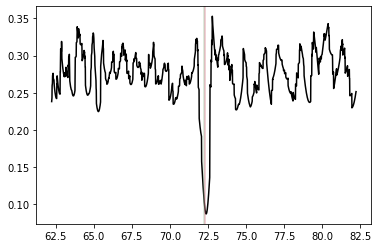

In [510]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

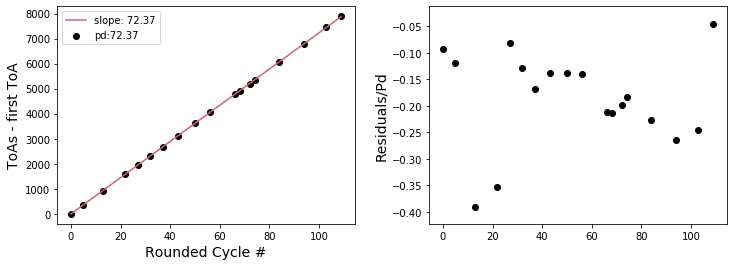

In [512]:
res(toas,minp)

116
False


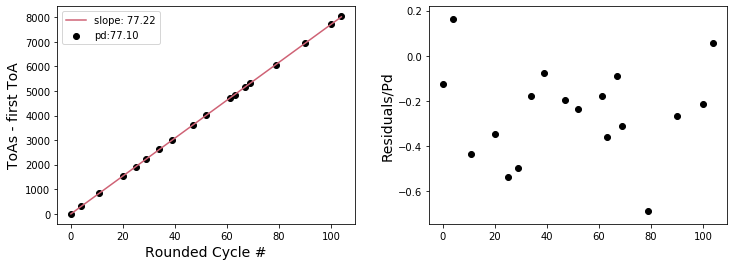

In [513]:
src = srcs[92]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 77.10


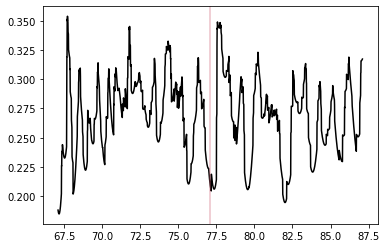

In [514]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

119
False


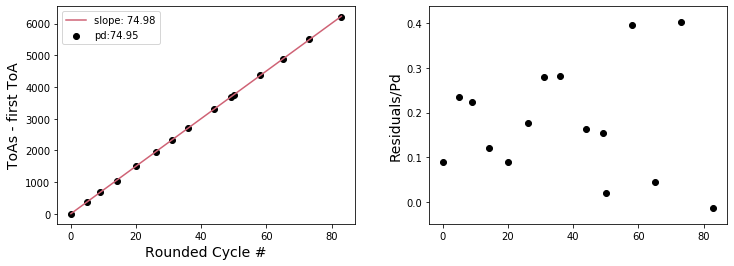

In [517]:
src = srcs[93]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 74.95


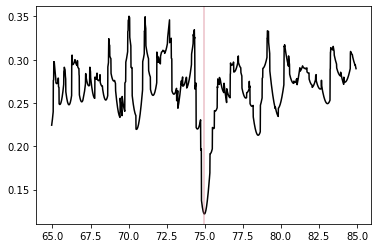

In [518]:
#new period
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

121
False


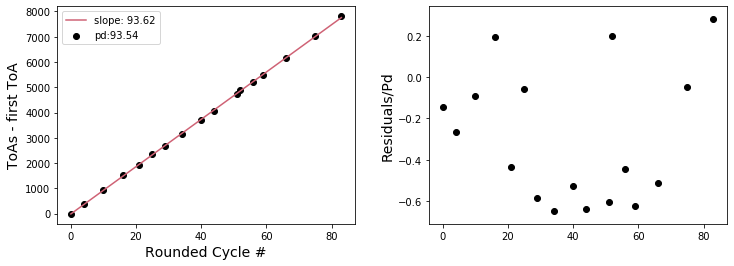

In [519]:
src = srcs[94]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 93.54


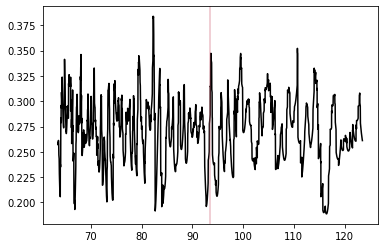

In [521]:
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

123
False


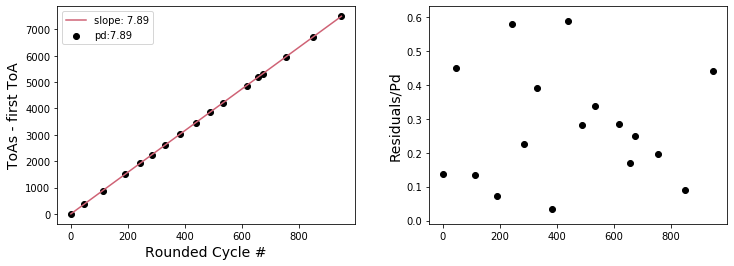

In [522]:
src = srcs[95]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 7.89


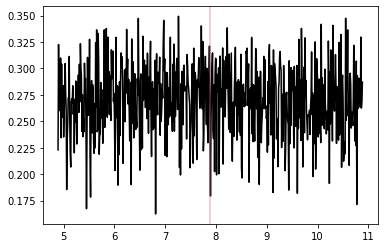

In [524]:
minp = toaloop(toas,pd-3,pd+3,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

124
False


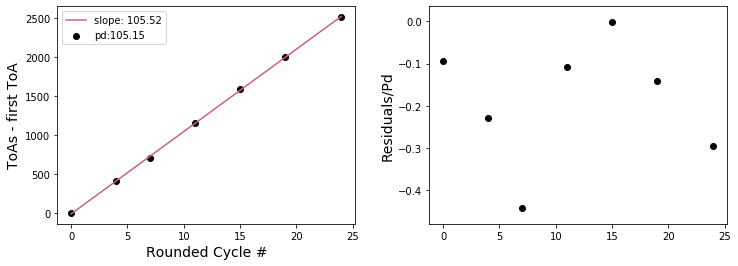

In [525]:
src = srcs[96]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 105.15


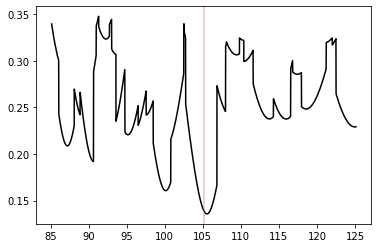

In [526]:
#good new period, though residuals quesitonable
minp = toaloop(toas,pd-20,pd+20,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

est: 0.0, best: 105.15
new best: 105.55


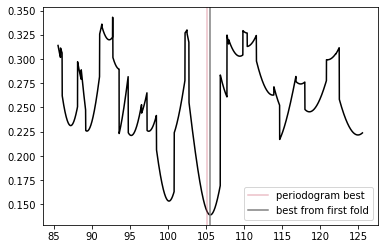

In [528]:
refold(search=20)

125
False


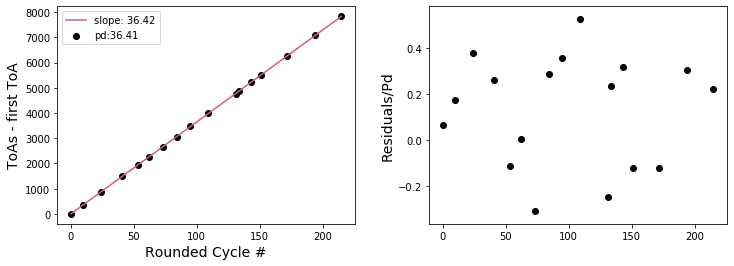

In [529]:
src = srcs[97]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 36.41, best: 35.79


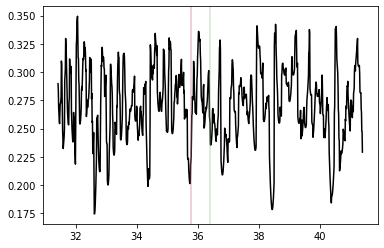

In [531]:
minp = toaloop(toas,pd-5,pd+5,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

126
False


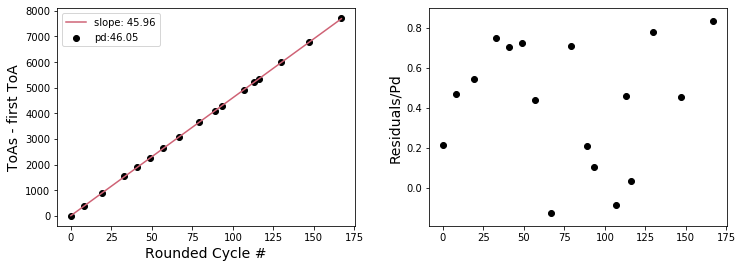

In [533]:
src = srcs[98] #bad residuals
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 46.05


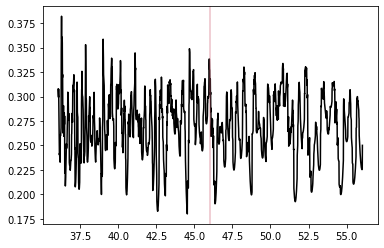

In [536]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

132
False


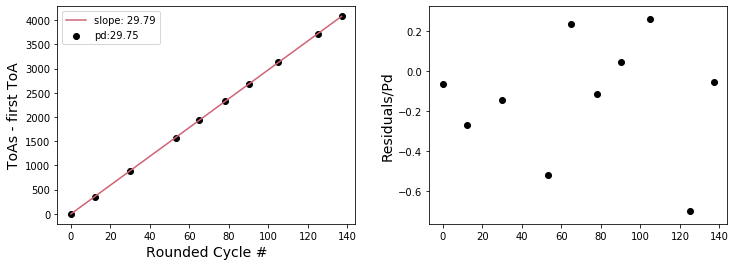

In [540]:
src = srcs[101]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 29.75, best: 28.53


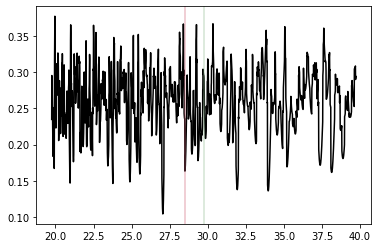

In [541]:
minp = toaloop(toas,pd-10,pd+10,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

136
False


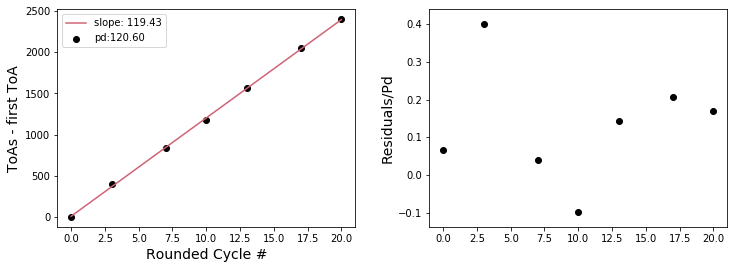

In [551]:
src = srcs[103]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 120.60


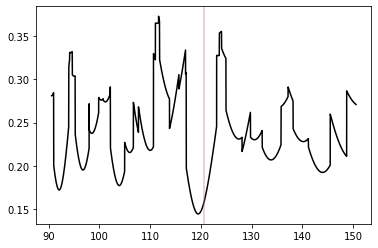

In [552]:
minp = toaloop(toas,pd-30,pd+30,0.01,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

139
False


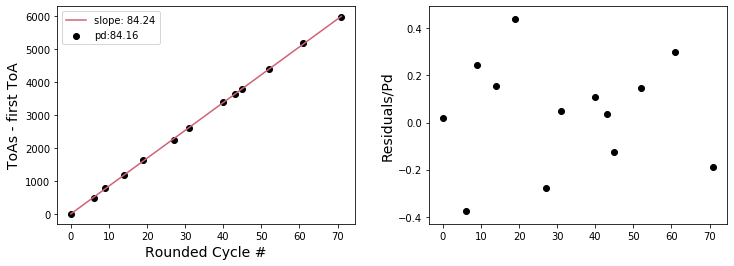

In [557]:
src = srcs[105]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=False)
res(toas,pd)
print(src in xlist) 

est: 0.0, best: 84.16


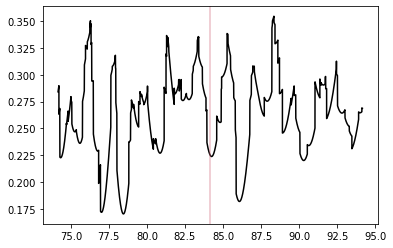

In [560]:
minp = toaloop(toas,pd-10,pd+10,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

142
False


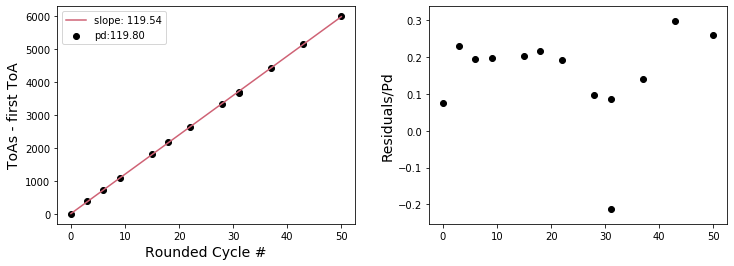

In [565]:
src = srcs[107]
print(src)
toas,pd = yearloop(src,0,mult=1,findpd='est',retpd=True,det=True)
res(toas,pd)
print(src in xlist) 

est: 119.8, best: 119.67


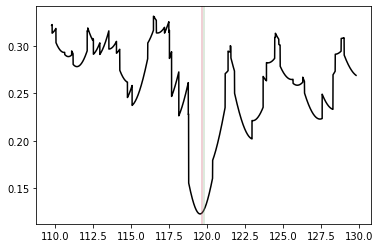

In [566]:
minp = toaloop(toas,pd-10,pd+10,0.001,color='black',retbest=True)
row = alls[alls['src_n']==src]
est = float(row['est. period'])
best = float(row['best auto det pd'])
if est!=0: plt.axvline(est,color='darkseagreen',alpha=0.4,label='est.')
plt.axvline(best,color=pink,alpha=0.4,label='periodogram best')

print(f'est: {est}, best: {best:.2f}')

# Automate Run for All Sources

In [105]:
#temp table
import pandas
ttab = pandas.DataFrame(columns=['src_n','pd used','best period'])

In [107]:
ttab['src_n'] = srcns

In [111]:
pds = []
bps = []
for s in srcns:
    try:
        auto = float(alls[alls['src_n']==s]['best auto det pd'])
        if auto>100: mult=2
        elif auto>200: mult=3
        else: mult=1
        toas,pd = yearloop(s,0,mult=mult,findpd='est',retpd=True)
        minp = toaloop(toas,pd-pd/5,pd+pd/5,0.01,color='black',retbest=True,plot=False)
        pds.append(pd),bps.append(minp)
    except: pds.append(np.nan),bps.append(np.nan)

empty file for OIII I
empty file for OII I
empty file for OIII I


In [116]:
ttab['pd used'] = pds
ttab['best period'] = bps

In [133]:
aps = []
for a in range(len(alls)):
    row = alls.iloc[a]
    if row['aperiodic'] == 'YES': aps.append(int(row['src_n']))

In [145]:
for t in range(len(ttab)):
    row = ttab.iloc[t]
    if int(row['src_n']) in aps:
        row['best period'] = np.nan
        ttab.iloc[t] = row

In [154]:
daycut = ttab[np.abs(ttab['best period']-ttab['pd used'])<1]
print(len(daycut))

39


for 39 sources, the best period is within a day of the period used for folding

In [155]:
#with percentage instead
percut = ttab[np.abs(ttab['best period']-ttab['pd used'])<ttab['pd used']/20]
print(len(percut))

40


for 40 sources, the best period is within 5% of the period used for folding

In [159]:
bcut = np.concatenate([daycut['src_n'],percut['src_n']])

In [162]:
len(np.unique(bcut))

48

48 sources fall into one of those two categories

now add the comparison to the best periodogram period for these sources


In [163]:
ttab['est. period'] = alls['est. period']

In [164]:
ttab['best auto'] = alls['best auto det pd']

In [165]:
#within 5% of established (remember not all have est)
percut2 = ttab[np.abs(ttab['best period']-ttab['est. period'])<ttab['est. period']/20]
print(len(percut2))

28


In [166]:
#within 5% of periodogram peak
percut2 = ttab[np.abs(ttab['best period']-ttab['best auto'])<ttab['best auto']/20]
print(len(percut2))

41


In [167]:
daycut2 = ttab[np.abs(ttab['best period']-ttab['best auto'])<1]
print(len(daycut2))

40


In [168]:
daycut2 = ttab[np.abs(ttab['best period']-ttab['est. period'])<1]
print(len(daycut2))

21


compare to confidence in periods

In [179]:
c = 0
for a in range(len(alls)):
    row = alls.iloc[a]
    if row['est. period']>0:c+=1

52 sources with established periods, so at least this many should have trustworthy ToA results


# Try out Iterative Re-folding Code
- re-find toas twice using new best periods and then average the three plots to get a final answer

In [13]:
a = np.zeros((2,3))
a[0] = [1,2,3]

In [18]:
np.mean(a,axis=0)

array([0.5, 1. , 1.5])

In [69]:
def iterate(src,num=3,step=0.01,plot=True):
    row = alls[alls['src_n']==src]
    auto = float(row['best auto det pd'])
    best = auto
    est = False
    if float(row['est. period'])>0: auto = float(row['est. period']);est=True
    if auto>100: mult=2
    elif auto>200: mult=3
    else:mult=1
    search = auto/5
    periods = np.arange(auto-search,auto+search,step)
    allstds = np.zeros((num,len(periods)))
    toas,pd = yearloop(src,0,mult=mult,findpd='est',retpd=True)
    stds,minp = toaloop(toas,auto-search,auto+search,step,color='black',retbest=True,plot=False,retstd=True)
    allstds[0] = stds
    for i in range(num-1):
        toas,pd = yearloop(src,minp,mult=mult,findpd='no',retpd=True)
        stds,minp = toaloop(toas,auto-search,auto+search,step,color='black',retbest=True,plot=False,retstd=True)
        allstds[i+1] = stds
    #average and plot the result
    mstd = np.mean(allstds,axis=0)
    if plot:
        plt.figure(figsize=(6,4))
        plt.plot(periods,mstd,color='black')
        plt.axvline(best,color=pink,alpha=0.4)
        if est:plt.axvline(auto,color='darkseagreen',alpha=0.4)
    #identify final best period
    bpind = np.where(mstd==np.nanmin(mstd))[0][0]
    bp = periods[bpind]
    return bp

39.81399999999845

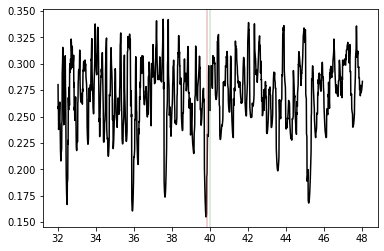

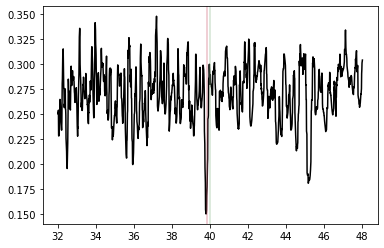

In [71]:
src = srcs[8]
iterate(src,num=1)
#good example of suppression of other signals
iterate(src) #num=3 is default

81.00999999999618

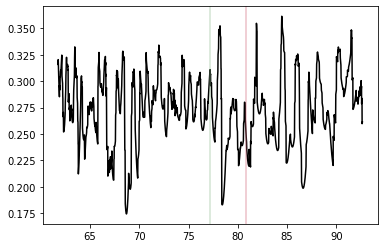

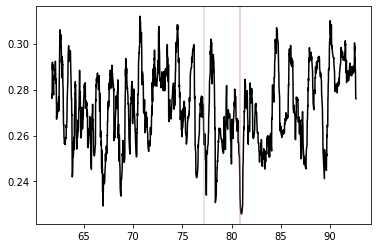

In [73]:
#legitimizes the best period a bit
src = srcs[10]
iterate(src,num=1)
iterate(src) 

63.07599999999954

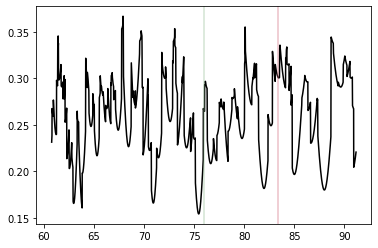

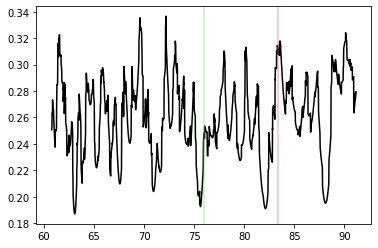

In [80]:
#best no longer close to est.
src = srcs[17]
iterate(src,num=1)
iterate(src)

67.22399999999743

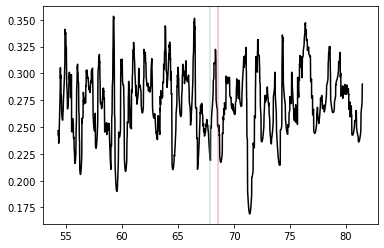

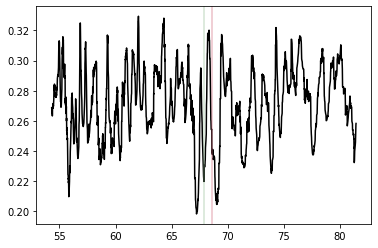

In [86]:
#improves dips near periods
src = srcs[32]
iterate(src,num=1)
iterate(src)

227.87999999995571

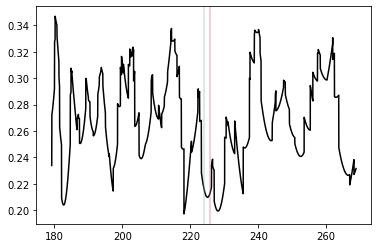

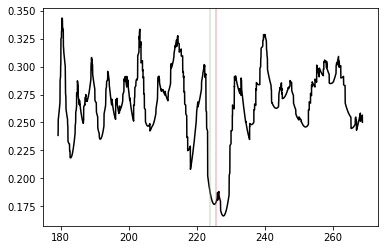

In [89]:
#improves
src = srcs[35]
iterate(src,num=1)
iterate(src)

128.39066992355671

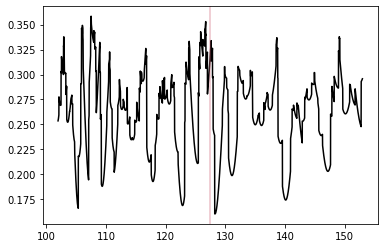

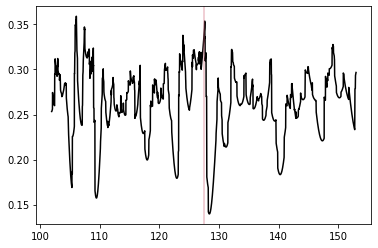

In [96]:
src = srcs[40]
iterate(src,num=1)
iterate(src,num=3)

379.9799999999047

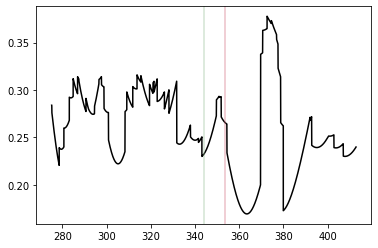

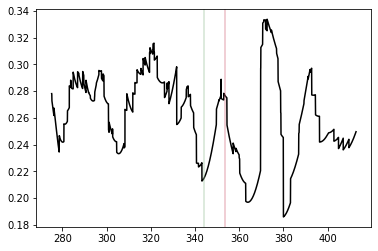

In [98]:
src = srcs[41]
iterate(src,num=1)
iterate(src)

129.879275715499

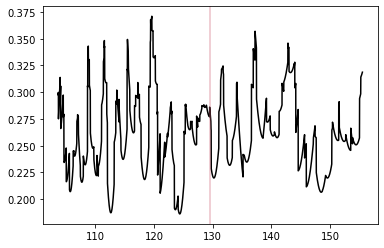

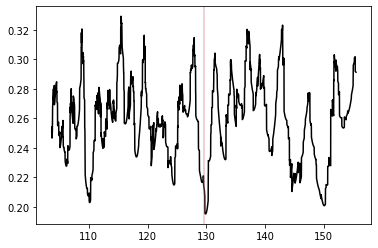

In [106]:
src = srcs[49]
iterate(src,num=1)
iterate(src)

153.52000000001675

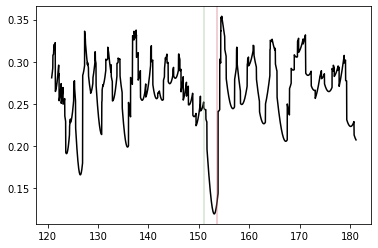

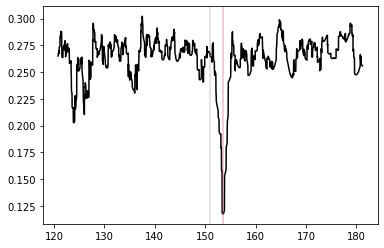

In [107]:
#improves and shows clearer preference for pdgram best
src = srcs[50]
iterate(src,num=1)
iterate(src)

# Test Minimizing Correlation in Residual Plot
- optimize minimization of both residual values and correlation